In [2]:
%%capture

!pip install cirq
!pip install xlrd
!pip install pysf
!pip install openfermion
!pip install openfermionpyscf
!pip install openfermioncirq

In [3]:
import cirq
import scipy
import pyscf
import openfermion
import openfermionpyscf 
import itertools
import pickle
import matplotlib.pyplot as plt
import numpy as np
import copy

from google.colab import files
from openfermionpyscf import run_pyscf
from openfermion.utils import count_qubits, hermitian_conjugated
from openfermion.linalg import jw_hartree_fock_state
from openfermion.circuits import simulate_trotter
from openfermion.transforms import (
    jordan_wigner, get_fermion_operator, normal_ordered
)
from openfermion import (
    get_sparse_operator, get_ground_state, FermionOperator,
    jw_get_ground_state_at_particle_number, MolecularData,
    expectation, uccsd_convert_amplitude_format,
    get_interaction_operator, QubitOperator, eigenspectrum,
    InteractionOperator, FermionOperator
)

## Function Definitions

In [4]:
# Define chemical accuracy
chemicalAccuracy = 1.5936*10**-3

# Define necessary Pauli operators (two-dimensional) as matrices
pauliX = np.array([[0,1],
                 [1,0]],
                dtype = complex)
pauliZ = np.array([[1,0],
                 [0,-1]],
                dtype = complex)
pauliY = np.array([[0,-1j],
                 [1j,0]],
                dtype = complex)

def stringToMatrix(pauliString):
  '''
  Converts a Pauli string to its matrix form.

  Arguments:
    pauliString (str): the Pauli string (e.g. "IXYIZ")

  Returns:
    matrix (np.ndarray): the corresponding matrix, in the computational basis

  '''

  matrix = np.array([1])

  # Iteratively construct the matrix, going through each single qubit Pauli term
  for pauli in pauliString:
      if pauli == "I":
        matrix = np.kron(matrix,np.identity(2))
      elif pauli == "X":
        matrix = np.kron(matrix,pauliX)
      elif pauli == "Y":
        matrix = np.kron(matrix,pauliY)
      elif pauli == "Z":
        matrix = np.kron(matrix,pauliZ)

  return matrix
  
def fromVectortoKet(stateVector):
  '''
  Transforms a vector representing a basis state to the corresponding ket.

  Arguments:
    stateVector (np.ndarray): computational basis vector in the 2^n dimensional 
      Hilbert space

  Returns:
    ket (list): a list of length n representing the corresponding ket 
  '''

  dim = len(stateVector)
  ket = []

  while dim>1:
    if any (stateVector[i] for i in range(int(dim/2))):
      # Ket is of the form |0>|...>. 

      #Fix |0> as the msq.
      ket.append(0)

      # Get the vector representing the state of the remaining qubits.
      stateVector = stateVector[:int(dim/2)]

    else:
      # Ket is of the form |1>|...>. 
      
      #Fix |0> as the msq.
      ket.append(1)

      # Get the vector representing the state of the remaining qubits.
      stateVector = stateVector[int(dim//2):]

    dim = dim/2

  return ket

def fromKettoVector(ket):
  '''
  Transforms a ket representing a basis state to the corresponding state vector.

  Arguments:
    ket (list): a list of length n representing the ket 

  Returns:
    stateVector (np.ndarray): the corresponding basis vector in the 
      2^n dimensional Hilbert space
  '''
  stateVector = [1]
  
  # Iterate through the ket, calculating the tensor product of the qubit states
  for i in ket:
    qubitVector = [not i,i]
    stateVector = np.kron(stateVector,qubitVector)

  return stateVector

def slaterDeterminantToKet(index, dimension):
  '''
  Transforms a Slater Determinant (computational basis state) into
    the corresponding ket.

  Arguments:
    index (int): the index of the non-zero element of the computational
      basis state.
    dimension (int): the dimension of the Hilbert space
  
  Returns:
    ket (list): the corresponding ket as a list of length dimension
    
  '''
  
  vector = [0 for _ in range (index)]+[1]+[1 for _ in range (dimension-index-1)]
  ket = fromVectortoKet(vector)

  return ket
  
def getHartreeFockKet(electronNumber,qubitNumber):
  '''
  Get the Hartree Fock ket |1>|1>...|0>|0>.

  Arguments:
    electronNumber (int): the number of electrons of the molecule.
    qubitNumber (int): the number of qubits necessary to represent the molecule
      (equal to the number of spin orbitals we're considering active).

  Returns:
    referenceKet (list): a list of lenght qubitNumber, representing the 
      ket of the adequate computational basis state in big-endian ordering.
  '''

  # Consider occupied the lower energy orbitals, until enough one particle 
  #states are filled
  referenceKet = [1 for _ in range(electronNumber)]

  # Consider the remaining orbitals empty
  referenceKet += [0 for _ in range(qubitNumber-electronNumber)]

  return referenceKet

def calculateOverlap(stateCoordinates1,stateCoordinates2):
    '''
    Calculates the overlap between two states, given their coordinates.

    Arguments:
      stateCoordinates1 (np.ndarray): the coordinates of one of the states in 
        some orthonormal basis,
      stateCoordinates2 (np.ndarray): the coordinates of the other state, in 
        the same basis

    Returns: 
      overlap (float): the overlap between two states (absolute value of the 
        inner product).
    '''

    bra = np.conj(stateCoordinates1)
    ket = stateCoordinates2
    overlap = np.abs(np.dot(bra,ket))
    
    return overlap

def findSubStrings(mainString,hamiltonian,checked = []):
    '''
    Finds and groups all the strings in a Hamiltonian that only differ from 
    mainString by identity operators.

    Arguments:
      mainString (str): a Pauli string (e.g. "XZ)
      hamiltonian (dict): a Hamiltonian (with Pauli strings as keys and their 
        coefficients as values)
      checked (list): a list of the strings in the Hamiltonian that have already
        been inserted in another group

    Returns: 
      groupedOperators (dict): a dictionary whose keys are boolean strings 
        representing substrings of the mainString (e.g. if mainString = "XZ", 
        "IZ" would be represented as "01"). It includes all the strings in the 
        hamiltonian that can be written in this form (because they only differ 
        from mainString by identities), except for those that were in checked
        (because they are already part of another group of strings).
      checked (list):  the same list passed as an argument, with extra values
        (the strings that were grouped in this function call).
    '''
    
    groupedOperators = {}
    
    # Go through the keys in the dictionary representing the Hamiltonian that 
    #haven't been grouped yet, and find those that only differ from mainString 
    #by identities
    for pauliString in hamiltonian:
        
        if pauliString not in checked:
            # The string hasn't been grouped yet
            
            if(all((op1 == op2 or op2 == "I") \
                   for op1,op2 in zip(mainString,pauliString))):
                # The string only differs from mainString by identities
                
                # Represent the string as a substring of the main one
                booleanString = "".join([str(int(op1 == op2)) for op1,op2 in \
                                       zip(mainString,pauliString)])
                    
                # Add the boolean string representing this string as a key to 
                #the dictionary of grouped operators, and associate its 
                #coefficient as its value
                groupedOperators[booleanString] = hamiltonian[pauliString]
                
                # Mark the string as grouped, so that it's not added to any 
                #other group
                checked.append(pauliString)
                
    return (groupedOperators,checked)

def groupHamiltonian(hamiltonian):
    '''
    Organizes a Hamiltonian into groups where strings only differ from 
    identities, so that the expectation values of all the strings in each 
    group can be calculated from the same measurement array.

    Arguments: 
      hamiltonian (dict): a dictionary representing a Hamiltonian, with Pauli 
        strings as keys and their coefficients as values.

    Returns: 
      groupedHamiltonian (dict): a dictionary of subhamiltonians, each of 
        which includes Pauli strings that only differ from each other by 
        identities. 
        The keys of groupedHamiltonian are the main strings of each group: the 
        ones with least identity terms. The value associated to a main string is 
        a dictionary, whose keys are boolean strings representing substrings of 
        the respective main string (with 1 where the Pauli is the same, and 0
        where it's identity instead). The values are their coefficients.
    '''
    groupedHamiltonian = {}
    checked = []
    
    # Go through the hamiltonian, starting by the terms that have less
    #identity operators
    for mainString in \
        sorted(hamiltonian,key = lambda pauliString: pauliString.count("I")):
            
        # Call findSubStrings to find all the strings in the dictionary that 
        #only differ from mainString by identities, and organize them as a 
        #dictionary (groupedOperators)
        groupedOperators,checked = findSubStrings(mainString,hamiltonian,checked)
        
        # Use the dictionary as a value for the mainString key in the 
        #groupedHamiltonian dictionary
        groupedHamiltonian[mainString] = groupedOperators
        
        # If all the strings have been grouped, exit the for cycle
        if(len(checked) == len(hamiltonian.keys())):
           break
       
    return groupedHamiltonian

def sampleEnergy(groupedHamiltonian,shots,statePreparationGates,qubits):
  '''
  Obtains the expectation value in a state by sampling (using the CIRQ 
  simulator).

  Arguments:
    groupedHamiltonian (dict): the Hamiltonian, grouped by terms that only differ
      by identities (as done by groupHamiltonian).
    shots (int): the number of circuit repetitions to be used.
    statePreparationGates (list): a list of CIRQ gates that prepare the state.
    qubits (list): a list of cirq.LineQubit to apply the gates on.

  Returns:
    energy (float): the energy (with sampling noise).
  '''

  energy = 0

  # Obtain the experimental expectation value for each Pauli string by
  #calling the measureExpectation function, and perform the necessary weighed
  #sum to obtain the energy expectation value
  for mainString in groupedHamiltonian:
      
      expectationValue = measureExpectation(mainString,
                                            groupedHamiltonian[mainString],
                                            shots,
                                            statePreparationGates,
                                            qubits)
      energy += expectationValue

  assert (energy.imag < 10**-10)
  
  return energy.real
    
def convertHamiltonian(openfermionHamiltonian):
  '''
  Formats a qubit Hamiltonian obtained from openfermion, so that it's a suitable
  argument for functions such as measureExpectationEstimation.

  Arguments:
    openfermionHamiltonian (openfermion.qubitOperator): the Hamiltonian.

  Returns:
    formattedHamiltonian (dict): the Hamiltonian as a dictionary with Pauli
      strings (eg 'YXZI') as keys and their coefficients as values.
  '''

  formattedHamiltonian = {}
  qubitNumber = count_qubits(openfermionHamiltonian)

  # Iterate through the terms in the Hamiltonian
  for term in openfermionHamiltonian.get_operators():

    operators = []
    coefficient = list(term.terms.values())[0]
    pauliString = list(term.terms.keys())[0]
    previousQubit = -1

    for (qubit,operator) in pauliString:

      # If there are qubits in which no operations are performed, add identities 
      #as necessary, to make sure that the length of the string will match the 
      #number of qubits
      identities = (qubit-previousQubit-1)
      if identities>0: 
        operators.append('I'*identities)

      operators.append(operator)
      previousQubit = qubit
    
    # Add final identity operators if the string still doesn't have the 
    #correct length (because no operations are performed in the last qubits)
    operators.append('I'*(qubitNumber-previousQubit-1))

    formattedHamiltonian["".join(operators)] = coefficient

  return formattedHamiltonian

def hamiltonianToMatrix(hamiltonian):
    '''
    Convert a Hamiltonian (from OpenFermion) to matrix form.
    
    Arguments:
      hamiltonian (openfermion.InteractionOperator): the Hamiltonian to be
        transformed.

    Returns:
      matrix (np.ndarray): the Hamiltonian, as a matrix in the computational 
        basis
    
    ''' 
    
    qubitNumber = hamiltonian.n_qubits
    
    hamiltonian = jordan_wigner(hamiltonian)

    formattedHamiltonian = convertHamiltonian(hamiltonian)
    groupedHamiltonian = groupHamiltonian(formattedHamiltonian)

    matrix = np.zeros((2**qubitNumber,2**qubitNumber),dtype = complex)

    # Iterate through the strings in the Hamiltonian, adding the respective 
    #contribution to the matrix
    for string in groupedHamiltonian:

      for substring in groupedHamiltonian[string]:
        pauli = ("".join("I"*(not int(b)) + a*int(b) \
                         for (a,b) in zip(string,substring)))
        
        matrix += stringToMatrix(pauli) * groupedHamiltonian[string][substring]

    return matrix

def measureString(pauliString,repetitions,statePreparationGates,qubits):
    ''' 
    Measures the expectation value of a Pauli string using the CIRQ simulator 
    (simulating sampling).

    Arguments:
      pauliString (str): the Pauli string to be measured.
      repetitions (int): the number of circuit repetitions to be used.
      statePreparationGates (list): the list of CIRQ gates that prepare the 
        state in which to obtain the expectation value.

    Returns: 
      expecationValue (float): the expectation value of pauliString, with 
        sampling noise.
    ''' 

    # Initialize circuit.
    circuit = cirq.Circuit(statePreparationGates)

    # Optimize circuit.
    cirq.optimizers.EjectZ().optimize_circuit(circuit)
    cirq.optimizers.DropNegligible().optimize_circuit(circuit)
    
    # Append necessary rotations and measurements for each qubit.
    for i in range(len(qubits)):
        op = pauliString[i]
        
        # Rotate qubit i to the X basis if that's the desired measurement.
        if (op == "X"):
            circuit.append(cirq.H(qubits[i]))
        
        # Rotate qubit i to the Y basis if that's the desired measurement.
        if (op == "Y"):
            circuit.append(cirq.rx(np.pi/2).on(qubits[i]))
            
        # Measure qubit i in the computational basis, unless operator is I.
        if (op != "I"):
            circuit.append(cirq.measure(qubits[i],key = str(i)))
            
    # Sample the desired number of repetitions from the circuit, unless
    #there are no measurements (identity term).
    if (pauliString != "I"*len(qubits)):
        s = cirq.Simulator()
        results = s.run(circuit,repetitions = repetitions)
    #print(circuit)

    # Calculate the expectation value of the Pauli string by averaging over  
    #all the repetitions.
    
    total = 0
    
    for j in range(repetitions):
        meas = 1
        for i in range(len(qubits)):
            if (pauliString[i] != "I"):
                meas = meas*(1-2*results.data[str(i)][j])
        total+=meas
        
    expectationValue = total/repetitions
    
    return expectationValue

def measureExpectation(mainString,subHamiltonian,repetitions,\
                       statePreparationGates,qubits):
    ''' 
    Measures the expectation value of a subHamiltonian using the CIRQ simulator 
    (simulating sampling). By construction, all the expectation values of the 
    strings in subHamiltonian can be obtained from the same measurement array.

    Arguments: 
      mainString (str): the main Pauli string. This is the string in the group
        with the least identity terms. It defines the circuit that will be used.
      subHamiltonian (dict): a dictionary whose keys are boolean strings
        representing substrings of the main one, and whose values are the 
        respective coefficients.
      repetitions (int): the number of repetitions to be performed, the 
      statePreparationGates (list): the list of CIRQ gates that prepare (from 
        |0..0>) the state in which to obtain the expectation value.
      qubits (list): list of cirq.LineQubit to apply the gates on

    Returns:
      totalExpectationValue (float): the total expectation value of 
        subHamiltonian, with sampling noise.
    ''' 
    
    # Initialize circuit.
    circuit = cirq.Circuit()
    
    # Append to the circuit the gates that prepare the state corresponding to
    #the received parameters.
    circuit.append(statePreparationGates)
    cirq.optimizers.EjectZ().optimize_circuit(circuit)
    cirq.optimizers.DropNegligible().optimize_circuit(circuit)
    
    # Append necessary rotations and measurements for each qubit.
    for i in range(len(qubits)):
        op = mainString[i]
        
        # Rotate qubit i to the X basis if that's the desired measurement.
        if (op == "X"):
            circuit.append(cirq.H(qubits[i]))
            
        # Rotate qubit i to the Y basis if that's the desired measurement.
        if (op == "Y"):
            circuit.append(cirq.rx(np.pi/2).on(qubits[i]))
            
        #Measure qubit i in the computational basis, unless operator is I.
        if (op != "I"):
            circuit.append(cirq.measure(qubits[i],key = str(i)))
            
    # Sample the desired number of repetitions from the circuit, unless
    #there are no measurements (identity term).
    if (mainString != "I"*len(qubits)):
        s = cirq.Simulator()
        results = s.run(circuit,repetitions = repetitions)

    # For each substring, initialize the sum of all measurements as zero
    total = {}
    for subString in subHamiltonian:
        total[subString] = 0
    
    # Calculate the expectation value of each Pauli string by averaging over  
    #all the repetitions
    for j in range(repetitions):
        meas = {}
        
        # Initialize the measurement in repetition j for all substrings
        for subString in subHamiltonian:
            meas[subString] = 1
        
        # Go through the measurements on all the qubits
        for i in range(len(qubits)):
            
            if (mainString[i] != "I"):
                # There's a measurement associated with this qubit
                
                # Use this single qubit measurement for the calculation of the
                #measurement of each full substring in this repetition. If the
                #substring has a "0" in the position corresponding to this
                #qubit, the operator associated is I, and the measurement
                #is ignored (raised to the power of 0)
                for subString in subHamiltonian:
                    meas[subString] = meas[subString]*((1-2*results.data[str(i)][j])\
                                                     **int(subString[i]))
                        
        # Add this measurement to the total, for each string
        for subString in subHamiltonian:
            total[subString]+=meas[subString]
        
    totalExpectationValue = 0
    
    # Calculate the expectation value of the subHamiltonian, by multiplying
    #the expectation value of each substring by the respective coefficient
    for subString in subHamiltonian:
        
        # Get the expectation value of this substring by taking the average
        #over all the repetitions
        expectationValue = total[subString]/repetitions
        
        # Add this value to the total expectation value, weighed by its 
        #coefficient
        totalExpectationValue+=expectationValue*subHamiltonian[subString]
    
    return totalExpectationValue

def stateEnergy(stateCoordinates,hamiltonian):
    ''' 
    Calculates the exact energy in a specific state.

    Arguments:
      stateCoordinates (np.ndarray): the state in which to obtain the 
        expectation value.
      hamiltonian (dict): the Hamiltonian of the system.
    
    Returns:
      exactEnergy (float): the energy expecation value in the state.
    ''' 

    exactEnergy = 0
    
    # Obtain the theoretical expectation value for each Pauli string in the
    #Hamiltonian by matrix multiplication, and perform the necessary weighed
    #sum to obtain the energy expectation value.
    for pauliString in hamiltonian:
        
        ket = np.array(stateCoordinates,dtype = complex)
        bra = np.conj(ket)
        
        ket = np.matmul(stringToMatrix(pauliString),ket)
        expectationValue = np.real(np.dot(bra,ket))
        
        exactEnergy+=\
            hamiltonian[pauliString]*expectationValue
            
    return exactEnergy

def trotterStep(operator,qubits,time): 
  '''
  Creates the circuit for applying e^(-j*operator*time), simulating the time
  evolution of a state under the Hamiltonian 'operator'.

  Arguments:
    operator (union[openfermion.QubitOperator, openfermion.FermionOperator,
      openfermion.InteractionOperator]): the operator to be simulated
    qubits ([cirq.LineQubit]): the qubits that the gates should be applied to
    time (float): the evolution time

  Returns:
    trotterGates (cirq.OP_TREE): the list of CIRQ gates that apply the 
      trotterized operator
  '''

  # If operator is an InteractionOperator, shape it into a FermionOperator
  if isinstance(operator,InteractionOperator):
    operator = get_fermion_operator(operator)

  # If operator is a FermionOperator, use the Jordan Wigner transformation
  #to map it into a QubitOperator
  if isinstance(operator,FermionOperator):
    operator = jordan_wigner(operator)
  
  # Get the number of qubits the operator acts on
  qubitNumber = count_qubits(operator)

  # Initialize list of gates
  trotterGates = []

  # Order the terms the same way as done by OpenFermion's 
  #trotter_operator_grouping function (sorted keys) for consistency.
  orderedTerms = sorted(list(operator.terms.keys()))

  # Add to trotterGates the gates necessary to simulate each Pauli string,
  #going through them by the defined order
  for pauliString in orderedTerms:

    # Get real part of the coefficient (the immaginary one can't be simulated,
    #as the exponent would be real and the operation would not be unitary).
    # Multiply by time to get the full multiplier of the Pauli string.
    coef = float(np.real(operator.terms[pauliString]))*time

    # Keep track of the qubit indices involved in this particular Pauli string.
    # It's necessary so as to know which are included in the sequence of CNOTs 
    #that compute the parity
    involvedQubits = []

    # Perform necessary basis rotations
    for pauli in pauliString:

      # Get the index of the qubit this Pauli operator acts on
      qubitIndex = pauli[0]
      involvedQubits.append(qubitIndex)

      # Get the Pauli operator identifier (X,Y or Z)
      pauliOp = pauli[1]

      if pauliOp == "X":
        # Rotate to X basis
        trotterGates.append(cirq.H(qubits[qubitIndex]))

      if pauliOp == "Y":
        # Rotate to Y Basis
        trotterGates.append(cirq.rx(np.pi/2).on(qubits[qubitIndex]))

    # Compute parity and store the result on the last involved qubit
    for i in range(len(involvedQubits)-1):

      control = involvedQubits[i]
      target = involvedQubits[i+1]

      trotterGates.append(cirq.CX(qubits[control],qubits[target]))
    
    # Apply e^(-i*Z*coef) = Rz(coef*2) to the last involved qubit
    lastQubit = max(involvedQubits)
    trotterGates.append(cirq.rz(2*coef).on(qubits[lastQubit]))

    # Uncompute parity
    for i in range(len(involvedQubits)-2,-1,-1):

      control = involvedQubits[i]
      target = involvedQubits[i+1]

      trotterGates.append(cirq.CX(qubits[control],qubits[target]))

    # Undo basis rotations
    for pauli in pauliString:

      # Get the index of the qubit this Pauli operator acts on
      qubitIndex = pauli[0]

      # Get the Pauli operator identifier (X,Y or Z)
      pauliOp = pauli[1]

      if pauliOp == "X":
        # Rotate to Z basis from X basis
        trotterGates.append(cirq.H(qubits[qubitIndex]))

      if pauliOp == "Y":
        # Rotate to Z basis from Y Basis
        trotterGates.append(cirq.rx(-np.pi/2).on(qubits[qubitIndex]))

  return trotterGates

def trotterizeOperator(operator,qubits,time,steps):
  '''
  Creates the circuit for applying e^(-j*operator*time), simulating the time
  evolution of a state under the Hamiltonian 'operator', with the given 
  number of steps. 
  Increasing the number of steps increases precision (unless the terms in the 
  operator commute, in which case steps = 1 is already exact).
  For the same precision, a greater time requires a greater step number
  (again, unless the terms commute)

  Arguments:
    operator (union[openfermion.QubitOperator, openfermion.FermionOperator,
      openfermion.InteractionOperator]): the operator to be simulated
    qubits ([cirq.LineQubit]): the qubits that the gates should be applied to
    time (float): the evolution time
    steps (int): the number of trotter steps to split the time evolution into

  Returns:
    trotterGates (cirq.OP_TREE): the list of CIRQ gates that apply the 
      trotterized operator
  '''
  
  trotterGates = []
  
  # Divide time into steps and apply the evolution operator the necessary 
  #number of times
  for step in range(1,steps+1):
    trotterGates += (trotterStep(operator,qubits,time/steps))
  
  return trotterGates

## Molecule Definitions


In [5]:
# H2
r = 0.74
geometry = [['H',[0,0,0]],['H',[0,0,r]]]
basis = 'sto-3g'
multiplicity = 1
charge = 0
h2molecule = MolecularData(geometry,basis,multiplicity,charge,description='H2')
h2molecule = run_pyscf(h2molecule,run_fci = True,run_ccsd = True)

# HeH+
r = 1 # interatomic distance in angstrom
geometry = [['He',[0,0,0]],['H',[0,0,r]]]
basis = 'sto-3g'
multiplicity = 1
charge = +1
helonium = MolecularData(geometry,basis,multiplicity,charge,description='HeH+')
helonium = run_pyscf(helonium,run_fci = True,run_ccsd = True)

# LiH
r = 2 # interatomic distance in angstrom
geometry = [['Li',[0,0,0]],['H',[0,0,r]]]
basis = 'sto-3g'
multiplicity = 1
charge = 0
liH = MolecularData(geometry,basis,multiplicity,charge,description='LiH')
liH = run_pyscf(liH,run_fci = True,run_ccsd = True)

# Alternative to using run_pyscf: load from OpenFermion (data for this 
#particular molecule at this particular interatomic distance is available in a 
#file that comes with OF)
liHOF = MolecularData(geometry,basis,multiplicity,charge,description = '1.45')
liHOF.load()

# LiHe
r = 1.45 # interatomic distance in angstrom
geometry = [['Li',[0,0,0]],['He',[0,0,r]]]
basis = 'sto-3g'
multiplicity = 2
charge = 0
liHe = MolecularData(geometry,basis,multiplicity,charge,description='LiHe')
liHe = run_pyscf(liHe,run_fci = True,run_ccsd = True)

# OH-
r = 1.45 # interatomic distance in angstrom
geometry = [['O',[0,0,0]],['H',[0,0,r]]]
basis = 'sto-3g'
multiplicity = 1
charge = -1
oH = MolecularData(geometry,basis,multiplicity,charge,description='OH-')
oH = run_pyscf(oH,run_fci = True,run_ccsd = True)

# BeH2
r = 2.5 # interatomic distance in angstrom
geometry = [['H',[0,0,-r]],['Be',[0,0,0]],['H',[0,0,+r]]]
basis = 'sto-3g'
multiplicity = 1
charge = 0
beH2 = MolecularData(geometry,basis,multiplicity,charge,description='BeH2')
beH2 = run_pyscf(beH2,run_fci = True,run_ccsd = True)

# H4
r = 1.5
geometry = [('H', (0,0,0)), ('H', (0,0,r)), ('H', (0,0,2*r)), 
            ('H', (0,0,3*r))]
basis = 'sto-3g'
multiplicity = 1
charge = 0
h4 = MolecularData(geometry,basis,multiplicity,charge,description='H4')
h4 = run_pyscf(h4,run_fci = True,run_ccsd = True)

# H6
r = 1.5
geometry = [('H', (0,0,0)), ('H', (0,0,r)), ('H', (0,0,2*r)), 
            ('H', (0,0,3*r)), ('H', (0,0,4*r)), ('H', (0,0,5*r))]
basis = 'sto-3g'
multiplicity = 1
charge = 0
h6 = MolecularData(geometry,basis,multiplicity,charge,description='H6')
h6 = run_pyscf(h6,run_fci = True,run_ccsd = True)

## Choosing the Molecule

In [6]:
molecule = liH
name = molecule.description
bondLength = molecule.geometry[1][1][2]

Get some data on the molecule. Only necessary for building the pools and testing; the functions are independent of previous data, and rely only on the MolecularData object.

In [7]:
electronNumber = molecule.n_electrons
orbitalNumber = molecule.n_orbitals
qubitNumber = molecule.n_qubits

hfState = jw_hartree_fock_state(electronNumber,orbitalNumber*2) 

hamiltonian = molecule.get_molecular_hamiltonian() 

# Get the matrix representing the Hamiltonian, as a scipy.sparse.csc_matrix
sparseHamiltonian = get_sparse_operator(hamiltonian,qubitNumber)

## Pool Definitions

Code for creating the fermionic pools (singlet_sd, singlet_gsd, spin_complement_gsd) taken from [the GitHub repository with the original Adapt-VQE implementation](https://github.com/mayhallgroup/adapt-vqe).

### Singlet Singles and Doubles

Spin preserving single and double excitations, occupied to virtual.

In [8]:
singlet_sd = []

n_occ = int(np.ceil(electronNumber / 2))
n_vir = orbitalNumber - n_occ

for i in range(0,n_occ):
    ia = 2*i
    ib = 2*i+1

    for a in range(0,n_vir):
        aa = 2*n_occ + 2*a
        ab = 2*n_occ + 2*a+1

        termA =  FermionOperator(((aa,1),(ia,0)), 1/np.sqrt(2))
        termA += FermionOperator(((ab,1),(ib,0)), 1/np.sqrt(2))

        termA -= hermitian_conjugated(termA)

        termA = normal_ordered(termA)

        #Normalize
        coeffA = 0
        for t in termA.terms:
            coeff_t = termA.terms[t]
            coeffA += coeff_t * coeff_t

        if termA.many_body_order() > 0:
            termA = termA/np.sqrt(coeffA)
            singlet_sd.append(termA)


for i in range(0,n_occ):
    ia = 2*i
    ib = 2*i+1

    for j in range(i,n_occ):
        ja = 2*j
        jb = 2*j+1

        for a in range(0,n_vir):
            aa = 2*n_occ + 2*a
            ab = 2*n_occ + 2*a+1

            for b in range(a,n_vir):
                ba = 2*n_occ + 2*b
                bb = 2*n_occ + 2*b+1

                termA =  FermionOperator(((aa,1),(ba,1),(ia,0),(ja,0)), 2/np.sqrt(12))
                termA += FermionOperator(((ab,1),(bb,1),(ib,0),(jb,0)), 2/np.sqrt(12))
                termA += FermionOperator(((aa,1),(bb,1),(ia,0),(jb,0)), 1/np.sqrt(12))
                termA += FermionOperator(((ab,1),(ba,1),(ib,0),(ja,0)), 1/np.sqrt(12))
                termA += FermionOperator(((aa,1),(bb,1),(ib,0),(ja,0)), 1/np.sqrt(12))
                termA += FermionOperator(((ab,1),(ba,1),(ia,0),(jb,0)), 1/np.sqrt(12))

                termB  = FermionOperator(((aa,1),(bb,1),(ia,0),(jb,0)), 1/2)
                termB += FermionOperator(((ab,1),(ba,1),(ib,0),(ja,0)), 1/2)
                termB += FermionOperator(((aa,1),(bb,1),(ib,0),(ja,0)), -1/2)
                termB += FermionOperator(((ab,1),(ba,1),(ia,0),(jb,0)), -1/2)

                termA -= hermitian_conjugated(termA)
                termB -= hermitian_conjugated(termB)

                termA = normal_ordered(termA)
                termB = normal_ordered(termB)

                #Normalize
                coeffA = 0
                coeffB = 0
                for t in termA.terms:
                    coeff_t = termA.terms[t]
                    coeffA += coeff_t * coeff_t
                for t in termB.terms:
                    coeff_t = termB.terms[t]
                    coeffB += coeff_t * coeff_t

                if termA.many_body_order() > 0:
                    termA = termA/np.sqrt(coeffA)
                    singlet_sd.append(termA)

                if termB.many_body_order() > 0:
                    termB = termB/np.sqrt(coeffB)
                    singlet_sd.append(termB)

print("Pool size:",len(singlet_sd))

Pool size: 44


### Singlet Generalized Singles and Doubles

Spin preserving single and double excitations, not only occupied to virtual, but also occupied to occupied and virtual to virtual.

**for** each spatial orbital $p$:
> **for** each spatial orbital $ q\geq p$:
>> $\hat{\tau}_1 = \lvert p \rangle \langle q \lvert + \lvert \bar{p} \rangle \langle \bar{q} \lvert $\
>> $\hat{\tau}_1 = \hat{\tau}_1 - \hat{\tau}_1^\dagger$\
>> Normal order $\hat{\tau}_1$\
>> **if** $\hat{\tau}_1$ **is not** $0$:
>>> Normalize $\hat{\tau}_1$ \
>>> Add $\hat{\tau}_1$ to the pool

**for** each spatial orbital $p$:
> **for** each spatial orbital $ q\geq p$:
>> **for** each spatial orbital $r$:
>>> **for** each spatial orbital $ s\geq r$:
>>>> **if** $(r,s) \geq (p,q)$ according to some unique ordering:
>>>>> $\hat{\tau}_{2,A} = -\frac{2}{\sqrt{12}} \lvert rs \rangle \langle pq \lvert$
>>>>> $\hat{\tau}_{2,A} = \hat{\tau}_{2,A} -\frac{2}{\sqrt{12}}\frac{1}{2}\left( \lvert r\bar{s} \rangle + \lvert \bar{r} s\rangle \right)\left( \langle p\bar{q} \lvert + \langle \bar{p} q\lvert \right) $
>>>>> $\hat{\tau}_{2,A} = \hat{\tau}_{2,A} -\frac{2}{\sqrt{12}} \lvert \bar{r}\bar{s} \rangle \langle \bar{p}\bar{q} \lvert$\
>>>>> $\hat{\tau}_{2,A} = \hat{\tau}_{2,A} - \hat{\tau}_{2,A}^\dagger$\
>>>>> $\hat{\tau}_{2,B} = -\frac{1}{2}\left( \lvert r\bar{s} \rangle - \lvert \bar{r} s\rangle \right)\left( \langle p\bar{q} \lvert - \langle \bar{p} q\lvert \right) $\
>>>>> $\hat{\tau}_{2,B} = \hat{\tau}_{2,B} - \hat{\tau}_{2,B}^\dagger$\
>>>>> Normal order $\hat{\tau}_{2,A}$\, $\hat{\tau}_{2,B}$\
>>>>> **for** $\hat{\tau}_{2}$ in {$\hat{\tau}_{2,A}$,$\hat{\tau}_{2,B}$}:
>>>>>> if $\hat{\tau}_{2}$  **is not** $0$:
>>>>>>> Normalize $\hat{\tau}_{2}$ \
>>>>>>> Add $\hat{\tau}_{2}$  to the pool

Second quantization formalism:

$\hat{\tau}_1 = a_p^\dagger a_q +a_\bar{p}^\dagger a_\bar{q} - h.c.$

$\hat{\tau}_{2,A} = \frac{1}{\sqrt{12}} \left( 2a_r^\dagger a_p a_s^\dagger a_q  + 2a_\bar{r}^\dagger a_\bar{p} a_\bar{s}^\dagger a_\bar{q} + a_r^\dagger a_p a_\bar{s}^\dagger a_\bar{q} + a_\bar{r}^\dagger a_\bar{p} a_s^\dagger a_q + a_r^\dagger a_\bar{p} a_\bar{s}^\dagger a_q + a_\bar{r}^\dagger a_p a_s^\dagger a_\bar{q} \right) - h.c.$

$\hat{\tau}_{2,B} = \frac{1}{2}\left(a_r^\dagger a_p a_\bar{s}^\dagger a_\bar{q} + a_\bar{r}^\dagger a_\bar{p} a_s^\dagger a_q - a_r^\dagger a_\bar{p} a_\bar{s}^\dagger a_q - a_\bar{r}^\dagger a_p a_s^\dagger a_\bar{q} \right) - h.c.$

First quantization formalism:

$\hat{\tau}_1 = \lvert p \rangle \langle q \lvert + \lvert \bar{p} \rangle \langle \bar{q} \lvert - h.c.$

$\hat{\tau}_{2,A} = -\frac{2}{\sqrt{12}} \left(\lvert rs \rangle \langle pq \lvert + \frac{1}{2}\left( \lvert r\bar{s} \rangle + \lvert \bar{r} s\rangle \right)\left( \langle p\bar{q} \lvert + \langle \bar{p} q\lvert \right) + \lvert \bar{r}\bar{s} \rangle \langle \bar{p}\bar{q} \lvert \right)-h.c.$
$= -\frac{2}{\sqrt{12}} \left(\lvert s=1,s_z=1 \rangle_{rs} \langle s=1,s_z=1 \lvert_{pq} + \lvert s=1,s_z=0 \rangle_{rs} \langle s=1,s_z=0 \lvert_{pq} +  \lvert s=1,s_z=-1 \rangle_{rs} \langle s=1,s_z=-1 \lvert_{pq} \right) - h.c $

$\hat{\tau}_{2,B} = -\frac{1}{2}\left( \lvert r\bar{s} \rangle - \lvert \bar{r} s\rangle \right)\left( \langle p\bar{q} \lvert - \langle \bar{p} q\lvert \right) - h.c. $

$ = -\frac{1}{2} \lvert s=0,s_z=0 \rangle_{rs} \langle s=0,s_z=0 \lvert_{pq} - h.c.$

In [9]:
singlet_gsd = []

for p in range(0,orbitalNumber):
    pa = 2*p
    pb = 2*p+1

    for q in range(p,orbitalNumber):
        qa = 2*q
        qb = 2*q+1

        termA =  FermionOperator(((pa,1),(qa,0)))
        termA += FermionOperator(((pb,1),(qb,0)))

        termA -= hermitian_conjugated(termA)
        termA = normal_ordered(termA)

        #Normalize
        coeffA = 0
        for t in termA.terms:
            coeff_t = termA.terms[t]
            coeffA += coeff_t * coeff_t

        if termA.many_body_order() > 0:
            termA = termA/np.sqrt(coeffA)
            singlet_gsd.append(termA)


pq = -1
for p in range(0,orbitalNumber):
    pa = 2*p
    pb = 2*p+1

    for q in range(p,orbitalNumber):
        qa = 2*q
        qb = 2*q+1

        pq += 1

        rs = -1
        for r in range(0,orbitalNumber):
            ra = 2*r
            rb = 2*r+1

            for s in range(r,orbitalNumber):
                sa = 2*s
                sb = 2*s+1

                rs += 1

                if(pq > rs):
                    continue

                termA =  FermionOperator(((ra,1),(pa,0),(sa,1),(qa,0)), 2/np.sqrt(12))
                termA += FermionOperator(((rb,1),(pb,0),(sb,1),(qb,0)), 2/np.sqrt(12))
                termA += FermionOperator(((ra,1),(pa,0),(sb,1),(qb,0)), 1/np.sqrt(12))
                termA += FermionOperator(((rb,1),(pb,0),(sa,1),(qa,0)), 1/np.sqrt(12))
                termA += FermionOperator(((ra,1),(pb,0),(sb,1),(qa,0)), 1/np.sqrt(12))
                termA += FermionOperator(((rb,1),(pa,0),(sa,1),(qb,0)), 1/np.sqrt(12))

                termB =  FermionOperator(((ra,1),(pa,0),(sb,1),(qb,0)),  1/2.0)
                termB += FermionOperator(((rb,1),(pb,0),(sa,1),(qa,0)),  1/2.0)
                termB += FermionOperator(((ra,1),(pb,0),(sb,1),(qa,0)), -1/2.0)
                termB += FermionOperator(((rb,1),(pa,0),(sa,1),(qb,0)), -1/2.0)

                termA -= hermitian_conjugated(termA)
                termB -= hermitian_conjugated(termB)

                termA = normal_ordered(termA)
                termB = normal_ordered(termB)

                #Normalize
                coeffA = 0
                coeffB = 0
                for t in termA.terms:
                    coeff_t = termA.terms[t]
                    coeffA += coeff_t * coeff_t
                for t in termB.terms:
                    coeff_t = termB.terms[t]
                    coeffB += coeff_t * coeff_t


                if termA.many_body_order() > 0:
                    termA = termA/np.sqrt(coeffA)
                    singlet_gsd.append(termA)

                if termB.many_body_order() > 0:
                    termB = termB/np.sqrt(coeffB)
                    singlet_gsd.append(termB)

print("Pool size:",len(singlet_gsd))

Pool size: 330


### Spin Complement Generalized Singles and Doubles

Spin complemented single and double excitations, occupied to virtual, virtual to virtual, or occupied to occupied.

**for** each spatial orbital $p$:
> **for** each spatial orbital $ q\geq p$:
>> $\hat{\tau}_1 = \lvert p \rangle \langle q \lvert + \lvert \bar{p} \rangle \langle \bar{q} \lvert $\
>> $\hat{\tau}_1 = \hat{\tau}_1 - \hat{\tau}_1^\dagger$\
>> Normal order $\hat{\tau}_1$\
>> **if** $\hat{\tau}_1$ **is not** $0$:
>>> Add $\hat{\tau}_1$ to the pool

**for** each spatial orbital $p$:
> **for** each spatial orbital $ q\geq p$:
>> **for** each spatial orbital $r$:
>>> **for** each spatial orbital $ s\geq r$:
>>>> **if** $(r,s) \geq (p,q)$ according to some unique ordering:
>>>>> $\hat{\tau}_{2,A} = - \left(\lvert rs \rangle \langle pq \lvert +\lvert \bar{r}\bar{s} \rangle \langle \bar{p}\bar{q} \lvert \right)$\
>>>>> $\hat{\tau}_{2,A} = \hat{\tau}_{2,A} - \hat{\tau}_{2,A}^\dagger$\
>>>>> $\hat{\tau}_{2,B} =- \left(\lvert r\bar{s} \rangle \langle p\bar{q} \lvert +\lvert \bar{r}s \rangle \langle \bar{p}q \lvert \right) $\
>>>>> $\hat{\tau}_{2,B} = \hat{\tau}_{2,B} - \hat{\tau}_{2,B}^\dagger$\
>>>>> $\hat{\tau}_{2,C} =- \left(\lvert r\bar{s} \rangle \langle \bar{p}q \lvert +\lvert \bar{r}s \rangle \langle p\bar{q} \lvert \right)$\
>>>>> $\hat{\tau}_{2,C} = \hat{\tau}_{2,C} - \hat{\tau}_{2,C}^\dagger$\
>>>>> Normal order $\hat{\tau}_{2,A}$\, $\hat{\tau}_{2,B}$\, $\hat{\tau}_{2,C}$\
>>>>> **for** $\hat{\tau}_{2}$ in {$\hat{\tau}_{2,A}$,$\hat{\tau}_{2,B}$,$\hat{\tau}_{2,C}$}:
>>>>>> if $\hat{\tau}_{2}$  **is not** $0$:
>>>>>>>Add $\hat{\tau}_{2}$  to the pool

First quantization formalism:

$\hat{\tau}_1 = \lvert p \rangle \langle q \lvert + \lvert \bar{p} \rangle \langle \bar{q} \lvert - h.c.$

$\hat{\tau}_{2,A} = - \left(\lvert rs \rangle \langle pq \lvert +\lvert \bar{r}\bar{s} \rangle \langle \bar{p}\bar{q} \lvert \right) - h.c. $

$\hat{\tau}_{2,B} =- \left(\lvert r\bar{s} \rangle \langle p\bar{q} \lvert +\lvert \bar{r}s \rangle \langle \bar{p}q \lvert \right) - h.c. $

$\hat{\tau}_{2,C} =- \left(\lvert r\bar{s} \rangle \langle \bar{p}q \lvert +\lvert \bar{r}s \rangle \langle p\bar{q} \lvert \right) - h.c. $


In [10]:
# spin_complement_gsd

spin_complement_gsd = []
for p in range(0,orbitalNumber):
    pa = 2*p
    pb = 2*p+1

    for q in range(p,orbitalNumber):
        qa = 2*q
        qb = 2*q+1

        termA =  FermionOperator(((pa,1),(qa,0)))
        termA += FermionOperator(((pb,1),(qb,0)))

        termA -= openfermion.hermitian_conjugated(termA)

        termA = openfermion.normal_ordered(termA)

        if termA.many_body_order() > 0:
            spin_complement_gsd.append(termA)

pq = -1
for p in range(0,orbitalNumber):
    pa = 2*p
    pb = 2*p+1

    for q in range(p,orbitalNumber):
        qa = 2*q
        qb = 2*q+1

        pq += 1

        rs = -1
        for r in range(0,orbitalNumber):
            ra = 2*r
            rb = 2*r+1

            for s in range(r,orbitalNumber):
                sa = 2*s
                sb = 2*s+1

                rs += 1

                if(pq > rs):
                    continue

                termA =  FermionOperator(((ra,1),(pa,0),(sa,1),(qa,0)))
                termA += FermionOperator(((rb,1),(pb,0),(sb,1),(qb,0)))

                termB =  FermionOperator(((ra,1),(pa,0),(sb,1),(qb,0)))
                termB += FermionOperator(((rb,1),(pb,0),(sa,1),(qa,0)))

                termC =  FermionOperator(((ra,1),(pb,0),(sb,1),(qa,0)))
                termC += FermionOperator(((rb,1),(pa,0),(sa,1),(qb,0)))

                termA -= openfermion.hermitian_conjugated(termA)
                termB -= openfermion.hermitian_conjugated(termB)
                termC -= openfermion.hermitian_conjugated(termC)

                termA = openfermion.normal_ordered(termA)
                termB = openfermion.normal_ordered(termB)
                termC = openfermion.normal_ordered(termC)

                if termA.many_body_order() > 0:
                  spin_complement_gsd.append(termA)

                if termB.many_body_order() > 0:
                    spin_complement_gsd.append(termB)

                if termC.many_body_order() > 0:
                    spin_complement_gsd.append(termC)

print("Pool Size:",len(spin_complement_gsd))

Pool Size: 540


### Generalized Singles and Doubles

In [11]:
# individual (not spin-complemented) double excitations

gsd = []
for p in range(0,orbitalNumber):
    pa = 2*p
    pb = 2*p+1

    for q in range(p,orbitalNumber):
        qa = 2*q
        qb = 2*q+1

        term1 = FermionOperator(((pa,1),(qa,0)))
        term2 = FermionOperator(((pb,1),(qb,0)))

        for term in [term1,term2]:

          term -= openfermion.hermitian_conjugated(term)
          term = openfermion.normal_ordered(term)

          if term.many_body_order() > 0:
              gsd.append(term)

pq = -1
for p in range(0,orbitalNumber):
    pa = 2*p
    pb = 2*p+1

    for q in range(p,orbitalNumber):
        qa = 2*q
        qb = 2*q+1

        pq += 1

        rs = -1
        for r in range(0,orbitalNumber):
            ra = 2*r
            rb = 2*r+1

            for s in range(r,orbitalNumber):
                sa = 2*s
                sb = 2*s+1

                rs += 1

                if(pq > rs):
                    continue

                terms = []
                #p = q 
                #r = s
                terms.append(FermionOperator(((ra,1),(pa,0),(sa,1),(qa,0))))
                terms.append(FermionOperator(((rb,1),(pb,0),(sb,1),(qb,0))))

                terms.append(FermionOperator(((ra,1),(pa,0),(sb,1),(qb,0))))
                #if p != q:
                  #terms.append(FermionOperator(((ra,1),(pb,0),(sb,1),(qa,0))))
                terms.append(FermionOperator(((ra,1),(pb,0),(sb,1),(qa,0))))

                terms.append(FermionOperator(((rb,1),(pb,0),(sa,1),(qa,0))))
                #if s != r:
                  #terms.append(FermionOperator(((rb,1),(pa,0),(sa,1),(qb,0))))
                terms.append(FermionOperator(((rb,1),(pa,0),(sa,1),(qb,0))))

                for term in terms:

                  term -= openfermion.hermitian_conjugated(term)
                  term = openfermion.normal_ordered(term)
                  if term.many_body_order() > 0 and term not in gsd:
                    gsd.append(term)

print("Pool Size:",len(gsd))
#print(gsd)

Pool Size: 1080


### Qubit Pool

#### Full Pool

**qubitPool**: the qubit pool as defined in qubit-ADAPT-VQE ([arxiv:1911.10205](https://arxiv.org/abs/1911.10205)). It consists of all unique Pauli strings appearing in the spin adapted generealized excitations (*singlet_gsd*).

In [12]:
pool = singlet_gsd

qubitPool = []

for fermionOp in pool:

  qubitOp = jordan_wigner(fermionOp)
  
  for pauli in qubitOp.terms:

    qubitOp = QubitOperator(pauli,1j)

    if qubitOp not in qubitPool:
      qubitPool.append(qubitOp)

print("Pool Size:",len(qubitPool))

Pool Size: 2700


#### Removed Z Strings

Obtained by removing from the previous pool the Z strings responsible for the anticommutation of the wavefunction.

In [13]:
noZQubitPool = []

for qubitOp in qubitPool:
  operator = list(qubitOp.get_operators())[0]
  pauliString = list(operator.terms.keys())[0]

  newOperator = QubitOperator((),1j)
  for qubit, operator in pauliString:
    if operator != 'Z':
      newOperator *= QubitOperator((qubit,operator))

  if newOperator not in noZQubitPool:
    noZQubitPool.append(newOperator)

print(len(noZQubitPool))

2100


#### Reduced Versions (YXXX, XYXX,...)

For each set of indices, without the Z-strings, there will be 8 possibilities of Pauli strings corresponding to double excitations: all the length 4 strings without Z operators, and with an odd number of each X and Y (even ones don't affect the energy, because they're symmetric).

(only indices whose sum is even are allowed, as there is no Sz-preserving excitation from e.g. alpha (even), beta (odd) to alpha, alpha) 

Since all strings acting on the same indices bring the same Slater determinants into the expansion, it is possible that only one string for each set of indices is necessary for convergence.

The following pools are obtained by either choosing a specific form of string, or introducing some randomness in picking which form is used for which indices.

**reducedQubitPool**: built from qubitPool by

*   Discarding the Z-string responsible for the anticommutation of fermions
*   Only keeping the first string acting on each set of spin orbitals

reducedQubitPool happens to be the same as xxyxPool, at least for H4; apparently, XXYX strings come first for all indices, so those are the ones that are always chosen. It's probably about some organization internal to OpenFermion.



In [14]:
reducedQubitPool = []
included = []

for qubitOp in qubitPool:
  operator = list(qubitOp.get_operators())[0]
  pauliString = list(operator.terms.keys())[0]

  newOperator = QubitOperator((),1j)
  indices = []
  for qubit, operator in pauliString:
    if operator != 'Z':
      newOperator *= QubitOperator((qubit,operator))
      indices.append(qubit)

  if indices not in included:
    reducedQubitPool.append(newOperator)
    included.append(indices)

print(len(reducedQubitPool))

285


In [15]:
# Alternative: get the pool directly from the singlet gsd pool

pool = singlet_gsd

included = []
reducedQubitPool2 = []

for fermionOp in pool:

  qubitOp = jordan_wigner(fermionOp)
  
  for pauli in qubitOp.get_operators():

    operator = list(pauli)[0]
    pauliString = list(operator.terms.keys())[0]

    newOperator = QubitOperator((),1j)
    indices = []

    for qubit, operator in pauliString:
      if operator != 'Z':
        newOperator *= QubitOperator((qubit,operator))
        indices.append(qubit)

    if indices not in included:
      reducedQubitPool2.append(newOperator)
      included.append(indices)

print(len(reducedQubitPool2))
print(reducedQubitPool==reducedQubitPool2)

285
True


In [16]:
yxxxPool = []

for a,b in itertools.combinations(range(qubitNumber),2):
  parity = (a + b) % 2

  if parity == 0:
    yxxxPool.append(QubitOperator(((a,'Y'),(b,'X')),1j))
    
for a,b,c,d in itertools.combinations(range(qubitNumber),4):
      paritySum = (a % 2 + b % 2 + c % 2 + d % 2)

      if paritySum % 2 == 0:
        yxxxPool.append(QubitOperator(((a,'Y'),(b,'X'),(c,'X'),(d,'X')),1j))

print(len(yxxxPool))

285


In [17]:
xyxxPool = []

for a,b in itertools.combinations(range(qubitNumber),2):
  parity = (a + b) % 2

  if parity == 0:
    xyxxPool.append(QubitOperator(((a,'Y'),(b,'X')),1j))
    
for a,b,c,d in itertools.combinations(range(qubitNumber),4):
      paritySum = (a % 2 + b % 2 + c % 2 + d % 2)

      if paritySum % 2 == 0:
        xyxxPool.append(QubitOperator(((a,'X'),(b,'Y'),(c,'X'),(d,'X')),1j))

print(len(xyxxPool))

285


In [18]:
xxyxPool = []

for a,b in itertools.combinations(range(qubitNumber),2):
  parity = (a + b) % 2

  if parity == 0:
    xxyxPool.append(QubitOperator(((a,'Y'),(b,'X')),1j))
    
for a,b,c,d in itertools.combinations(range(qubitNumber),4):
      paritySum = (a % 2 + b % 2 + c % 2 + d % 2)

      if paritySum % 2 == 0:
        xxyxPool.append(QubitOperator(((a,'X'),(b,'X'),(c,'Y'),(d,'X')),1j))

print(len(xxyxPool))

285


In [19]:
xxxyPool = []

for a,b in itertools.combinations(range(qubitNumber),2):
  parity = (a + b) % 2

  if parity == 0:
    xxxyPool.append(QubitOperator(((a,'Y'),(b,'X')),1j))
    
for a,b,c,d in itertools.combinations(range(qubitNumber),4):
      paritySum = (a % 2 + b % 2 + c % 2 + d % 2)

      if paritySum % 2 == 0:
        xxxyPool.append(QubitOperator(((a,'X'),(b,'X'),(c,'X'),(d,'Y')),1j))

print(len(xxxyPool))

285


In [20]:
randomPool = []
stringOptions = [yxxxPool,xyxxPool,xxyxPool,xxxyPool]

for i in range(len(xxxyPool)):
  chosen = np.random.randint(0,4)
  randomPool.append(stringOptions[chosen][i])

print(len(randomPool))

285


#### Two / Four / Eight Pools

The previous reduced pools seem to have issues when there are many Slater determinants with wrong values of particle number and Sz in the expansion. The reason why these different strings appear in the pool to begin with, is that they're all part of the same excitation, and force it to preserve these expectation values.

So it's not surprising that keeping only one type of them in the pool affects convergence: they bring the same Slater determinants into the expression, but there can be different local phases that allow creating destructive interference to lower the prevalence of determinants with incorrect Sz / particle number in the state. These determinants have zero overlap with the ground state.

A different possibility is grouping them, such that there are less operators in the pool, but they preserve (either completely or more often than the individual strings) these expectation values.

That is the idea of the following pools. In the singlet double excitations, there were several terms (products of second quantized operators) per excitation operator; each of them corresponds to a sum of (after -h.c.) 8 Pauli strings.

This is necessary to preserve $N$, $S_z$, and $S^2$. For preserving the first two, the sum of 8 Paulis arising from a product of single second quantized operators is enough. But it isn't necessary: the purpose of the 8 Paulis is being faithfull to the action of the excitation. They're also cancelling out the rotation of a Slater determinant to another one with the same $N$ and $S_Z$, when they don't differ by a double excitation or deexcitation. 

To preserve these expectation values, it is enough to use 4 strings, that will depend on the type of excitation (which orbitals have up or down spin). 2 are enough to cancell out excitations envolving an odd number of fermions, that represent a sizeable portion of the wrong excitations (especially in molecules like HeH+ and H2: the Hartree Fock state is |00001111>, so these 2 strings are enough to prevent reaching any wrong state except for |00000000> and |11111111>).

As for single excitations, a parity check is enough, so they just need to be grouped two by two.

The eight pool is directly obtained from the generalized singles and doubles pools, by removing the Z strings. It's bigger than the other pools, because it may have e.g. one operator from 23->45 and a different one from 24->35. The two / four pools only have one operator for each set of 4 spin orbitals (as long as it's valid, having an even number of alpha and beta spins).

In [21]:
baseString = "XXYX"

op1 = baseString[0]
op2 = baseString[1]
op3 = baseString[2]
op4 = baseString[3]

In [22]:
twoPool = []

for a,b in itertools.combinations(range(qubitNumber),2):
  parity = (a + b) % 2
  if parity == 0:

    operator = QubitOperator(((a,'Y'),(b,'X')),1j)

    z = QubitOperator(()) - QubitOperator(((a,'Z'),(b,'Z')))

    twoPool.append(operator * z)

for a,b,c,d in itertools.combinations(range(qubitNumber),4):
  
      paritySum = (a % 2 + b % 2 + c % 2 + d % 2)

      if paritySum % 2 == 0:

        operator = QubitOperator(((a,op1),(b,op2),(c,op3),(d,op4)),1j)

        z = QubitOperator(()) + QubitOperator(((a,'Z'),(b,'Z'),(c,'Z'),(d,'Z')))
        
        twoPool.append(operator * z)

print(len(twoPool))

285


In [23]:
fourPool = []

for a,b in itertools.combinations(range(qubitNumber),2):
  parity = (a + b) % 2

  if parity == 0:

    operator = QubitOperator(((a,'Y'),(b,'X')),1j)

    z = QubitOperator(()) - QubitOperator(((a,'Z'),(b,'Z')))

    fourPool.append(operator * z)

for a,b,c,d in itertools.combinations(range(qubitNumber),4):
  
      paritySum = (a % 2 + b % 2 + c % 2 + d % 2)

      if paritySum % 2 == 0:

        operator = QubitOperator(((a,op1),(b,op2),(c,op3),(d,op4)),1j)

        z1 = QubitOperator(()) + QubitOperator(((a,'Z'),(b,'Z'),(c,'Z'),(d,'Z')))
        '''
        if (a % 2 == b % 2):
          # aabb, bbaa, aaaa, bbbb
          z2 = QubitOperator(()) - QubitOperator((             (c,'Z'),(d,'Z')))

        elif (a % 2 == c % 2):
          # abab, baba
          z2 = QubitOperator(()) - QubitOperator((        (b,'Z'),     (d,'Z')))
        
        else:
          # abba, baab
          z2 = QubitOperator(()) - QubitOperator(((a,'Z'),             (d,'Z')))
        '''

        if (a % 2 == b % 2 and c % 2 == d % 2 and b % 2 == c % 2):
          # aaaa, bbbb
          z2 = QubitOperator(()) - QubitOperator((             (c,'Z'),(d,'Z')))
          fourPool.append(operator * z1 * z2)

          z2 = QubitOperator(()) - QubitOperator((        (b,'Z'),     (d,'Z')))
          fourPool.append(operator * z1 * z2)

          z2 = QubitOperator(()) - QubitOperator(((a,'Z'),             (d,'Z')))

        elif (a % 2 == b % 2):
          # aabb, bbaa
          z2 = QubitOperator(()) - QubitOperator((             (c,'Z'),(d,'Z')))

        elif (a % 2 == c % 2):
          # abab, baba
          z2 = QubitOperator(()) - QubitOperator((        (b,'Z'),     (d,'Z')))
        
        else:
          # abba, baab
          z2 = QubitOperator(()) - QubitOperator(((a,'Z'),             (d,'Z')))
        
        fourPool.append(operator * z1 * z2)

print(len(fourPool))

345


In [24]:
print(fourPool)

[(-0-1j) [X0 Y2] +
1j [Y0 X2], (-0-1j) [X0 Y4] +
1j [Y0 X4], (-0-1j) [X0 Y6] +
1j [Y0 X6], (-0-1j) [X0 Y8] +
1j [Y0 X8], (-0-1j) [X0 Y10] +
1j [Y0 X10], (-0-1j) [X1 Y3] +
1j [Y1 X3], (-0-1j) [X1 Y5] +
1j [Y1 X5], (-0-1j) [X1 Y7] +
1j [Y1 X7], (-0-1j) [X1 Y9] +
1j [Y1 X9], (-0-1j) [X1 Y11] +
1j [Y1 X11], (-0-1j) [X2 Y4] +
1j [Y2 X4], (-0-1j) [X2 Y6] +
1j [Y2 X6], (-0-1j) [X2 Y8] +
1j [Y2 X8], (-0-1j) [X2 Y10] +
1j [Y2 X10], (-0-1j) [X3 Y5] +
1j [Y3 X5], (-0-1j) [X3 Y7] +
1j [Y3 X7], (-0-1j) [X3 Y9] +
1j [Y3 X9], (-0-1j) [X3 Y11] +
1j [Y3 X11], (-0-1j) [X4 Y6] +
1j [Y4 X6], (-0-1j) [X4 Y8] +
1j [Y4 X8], (-0-1j) [X4 Y10] +
1j [Y4 X10], (-0-1j) [X5 Y7] +
1j [Y5 X7], (-0-1j) [X5 Y9] +
1j [Y5 X9], (-0-1j) [X5 Y11] +
1j [Y5 X11], (-0-1j) [X6 Y8] +
1j [Y6 X8], (-0-1j) [X6 Y10] +
1j [Y6 X10], (-0-1j) [X7 Y9] +
1j [Y7 X9], (-0-1j) [X7 Y11] +
1j [Y7 X11], (-0-1j) [X8 Y10] +
1j [Y8 X10], (-0-1j) [X9 Y11] +
1j [Y9 X11], 1j [X0 X1 Y2 X3] +
1j [X0 Y1 Y2 Y3] +
(-0-1j) [Y0 X1 X2 X3] +
-1j [Y0 Y1 X2 Y3]

In [25]:
eightPool = []
#included = []

for fermionOp in gsd:
  qubitOp = jordan_wigner(fermionOp)
  operators = list(qubitOp.get_operators())[0]

  newOperator = QubitOperator((),0)

  for term in qubitOp.get_operators():

    coefficient = list(term.terms.values())[0]
    pauliString = list(term.terms.keys())[0]

    newPauli = QubitOperator((),coefficient)

    indices = []
    for qubit, operator in pauliString:
      if operator != 'Z':
        newPauli *= QubitOperator((qubit,operator))
        indices.append(qubit)

    newOperator += newPauli

  '''
  if indices not in included:
    eightPool.append(newOperator)
    included.append(indices)
    print("2\n",newOperator,"\n")
  '''
  if newOperator not in eightPool and -newOperator not in eightPool:
    eightPool.append(newOperator)

print(len(eightPool))

571


In [26]:
print(eightPool)

[0.5j [X0 Y2] +
-0.5j [Y0 X2], 0.5j [X1 Y3] +
-0.5j [Y1 X3], 0.5j [X0 Y4] +
-0.5j [Y0 X4], 0.5j [X1 Y5] +
-0.5j [Y1 X5], 0.5j [X0 Y6] +
-0.5j [Y0 X6], 0.5j [X1 Y7] +
-0.5j [Y1 X7], 0.5j [X0 Y8] +
-0.5j [Y0 X8], 0.5j [X1 Y9] +
-0.5j [Y1 X9], 0.5j [X0 Y10] +
-0.5j [Y0 X10], 0.5j [X1 Y11] +
-0.5j [Y1 X11], 0.5j [X2 Y4] +
-0.5j [Y2 X4], 0.5j [X3 Y5] +
-0.5j [Y3 X5], 0.5j [X2 Y6] +
-0.5j [Y2 X6], 0.5j [X3 Y7] +
-0.5j [Y3 X7], 0.5j [X2 Y8] +
-0.5j [Y2 X8], 0.5j [X3 Y9] +
-0.5j [Y3 X9], 0.5j [X2 Y10] +
-0.5j [Y2 X10], 0.5j [X3 Y11] +
-0.5j [Y3 X11], 0.5j [X4 Y6] +
-0.5j [Y4 X6], 0.5j [X5 Y7] +
-0.5j [Y5 X7], 0.5j [X4 Y8] +
-0.5j [Y4 X8], 0.5j [X5 Y9] +
-0.5j [Y5 X9], 0.5j [X4 Y10] +
-0.5j [Y4 X10], 0.5j [X5 Y11] +
-0.5j [Y5 X11], 0.5j [X6 Y8] +
-0.5j [Y6 X8], 0.5j [X7 Y9] +
-0.5j [Y7 X9], 0.5j [X6 Y10] +
-0.5j [Y6 X10], 0.5j [X7 Y11] +
-0.5j [Y7 X11], 0.5j [X8 Y10] +
-0.5j [Y8 X10], 0.5j [X9 Y11] +
-0.5j [Y9 X11], , -0.125j [X0 X1 X2 Y3] +
-0.125j [X0 X1 Y2 X3] +
0.125j [X0 Y1 X2 X3] +
-0.125

#### Minimal Pools 

These scale like 2n-2 on the number of orbitals. They're provably able to transform any real state into |0...0>, and so transform any real state into any real state. 

However, I can't get them to work. The derivatives are all zero in the Hartree Fock state, and even if they're added by force they won't bring the energy down: the optimal point will be zero.

This seems like it has something to do with particle number preservation. None of the operators preserve the particle number (or Sz) in a computational basis state. How can the overlap with the ground state increase, if we're only rotating a Slater determinant with the correct particle number into a superposition involving another one with a wrong particle number?

In [27]:
# G from the qubit-ADAPT article (appendix C)

k = qubitNumber - 1
minimalPool3 = []
for i in range(qubitNumber-1):
  operator = QubitOperator(((k - i,"Z") , (k - (i+1),"Y")), 1j)
  minimalPool3.append(operator)
  operator = QubitOperator( ((k - i,"Y")) , 1j)
  minimalPool3.append(operator)

# V from the qubit-ADAPT article (appendix C)

minimalPool4 = []
for i in range(qubitNumber):
  operator = QubitOperator(([(k-j,"Z") for j in range(i)] + [(k-i,"Y")]), 1j)
  minimalPool4.append(operator)
  if i != 0 and i != qubitNumber - 1:
    operator = QubitOperator(([(k-j,"Z") for j in range(i-1)] + [(k-i,"Y")]), 1j)
    minimalPool4.append(operator)

print("Pool Size:",len(minimalPool3))

Pool Size: 22


### Estimating #CNOT/Param

Lower bound (assumes all-to-all connectivity).

In [28]:
def countCNOTs(operatorList):
  '''
  Counts the number of CNOTs necessary for the trotterization 
  (1 step) of all operators in a list.

  Arguments:
    operatorList (list): QubitOperators or FermionOperators
      to be considered

  Returns:
    cnotCount (int): the total number of qubits, assuming
      all qubits are connected to all qubits
  '''

  cnotCount = 0

  for op in operatorList:

    if isinstance(op,FermionOperator):
      qubitOp = jordan_wigner(op)
    else:
      qubitOp = op

    for term in qubitOp.get_operators():
      
      term = list(term)[0]
      pauli = list(term.terms.keys())[0]
      stringLen = len(pauli)
      cnotCount += 2*stringLen - 2

  return cnotCount

The eight pool operators can be implemented with fewer CNOTs (arxiv:2011.10540).

In [29]:
def countEightPoolCNOTs(operatorList):
  '''
  Counts the number of CNOTs necessary for implementing
  the full operatorList, that should be a list of qubit excitations.

  Arguments:
    operatorList (list): QubitOperators or FermionOperators
      to be considered, belonging to the eightPool

  Returns:
    cnotCount (int): the total number of qubits, assuming
      all qubits are connected to all qubits
  '''

  cnotCount = 0

  for op in operatorList:

    if isinstance(op,FermionOperator):
      qubitOp = jordan_wigner(op)
    else:
      qubitOp = op
    
    pauliList = list(qubitOp.get_operators())[1:]
    termCount = len(pauliList)

    assert termCount == 2 or termCount == 8

    if termCount == 2:
      # Single excitation; can be implemented with 2 cnots
      cnotCount += 2
    if termCount == 8:
      # Double excitation; 13 cnots
      cnotCount += 13

  return cnotCount

In [30]:
# Choose pool to consider

pool = singlet_gsd

cnotCount = countCNOTs(pool)
average = int(cnotCount/len(pool))

print("Average number of CNOTs per operator: {}".format(average))

Average number of CNOTs per operator: 294


## Loose Functions

In [31]:
def computeEnergy(coefficients,
                  sparsePool,
                  sparseHamiltonian, 
                  sparseReferenceState,
                  indices):
  '''
  Calculates the energy in a given Adapt VQE state.

  Arguments:
      coefficients (list): coefficients of the ansatz indices
      sparsePool (list): the pool in use, as a list of sparse matrices
      sparseHamiltonian (scipy.sparse.csc_matrix): the Hamiltonian, as a sparse
        matrix
      sparseReferecenState (scipy.sparse.csc_matrix): the state vector to be
        used as reference
      indices (list): indices that specify which operators are in the ansatz
      
    Returns:
      energy (float): the expectation value of the energy in this state
    
  '''
  
  ket = sparseReferenceState

  # Apply e ** (coefficient * operator) to the state (ket) for each operator in 
  #the ansatz, following the order of the list
  for (coefficient,operatorIndex) in zip(coefficients,indices):

    # Multiply the operator by the respective coefficient
    sparseOperator = coefficient * sparsePool[operatorIndex]

    # Exponentiate the operator and update ket to represent the state after
    #this operator has been applied
    expOperator = scipy.sparse.linalg.expm(sparseOperator)
    ket = expOperator * ket

  # Get the corresponding bra and calculate the energy: |<bra| H |ket>|
  bra = ket.transpose().conj()
  energy = (bra * sparseHamiltonian * ket)[0,0].real

  return energy

def calculateGradient(operator,state,sparseHamiltonian):
  '''
    Calculates the gradient of a given operator in the current state.
    Uses dexp(c*A)/dc = <psi|[H,A]|psi> = 2 * real(<psi|HA|psi>).
    This is the gradient calculated at c = 0.

    Arguments:
      operatorIndex (union[openfermion.QubitOperator, 
        openfermion.FermionOperator): the operator
      state (scipy.sparse.csc_matrix): the state in which to calculate the
        gradient
      sparseHamiltonian (scipy.sparse.csc_matrix): the sparse matrix 
        representing the Hamiltonian of the system
    
    Returns:
      gradient (float): the norm of the gradient of this operator in the 
        current state
  '''

  dimension, _ = sparseHamiltonian.shape
  qubitNumber = int(np.log(dimension)/np.log(2)) 

  sparseOperator = get_sparse_operator(operator,qubitNumber)
  
  testState = sparseOperator * state

  bra = state.transpose().conj()
  gradient = 2 * (np.abs(bra * sparseHamiltonian * testState)[0,0].real)

  return gradient

def computeState(sparseReferenceState,coefficients,indices,sparsePool):
  '''
  Computes the state prepared by an Adapt VQE ansatz.

  Arguments:
      sparseReferecenState (scipy.sparse.csc_matrix): the state vector to be
        used as reference
      coefficients (list): coefficients of the ansatz indices
      indices (list): indices that specify which operators are in the ansatz
      sparsePool (list): the pool in use, as a list of sparse matrices

  Returns:
    state (scipy.sparse.csc_matrix): the sparse vector representing the state
  '''

  # Initialize the state vector with the reference state.
  state = sparseReferenceState

  # Apply the ansatz operators one by one to obtain the state as optimized
  #by the last iteration
  for (i,operatorIndex) in enumerate(indices):

    # Obtain the exponentiated pool operator, multiplied by the respective
    #variational parameter (as optimized by the last iteration)
    coefficient = coefficients[i]
    sparseOperator = sparsePool[operatorIndex].multiply(coefficient)
    expOperator = scipy.sparse.linalg.expm(sparseOperator)

    # Act on the state with the operator 
    state = expOperator * state

  return state

def getSparsePool(pool,qubitNumber):
  '''
  Obtains a sparse version of the operator pool.

  Arguments:
    pool (list): the pool as a list of QubitOperators or FermionOperators
    qubitNumber (list): the number of qubits in use (= number of spin orbitals)

  Returns:
    sparsePool (list): the pool as a list of sparseMatrices
  '''
  
  sparsePool = []

  for operator in pool:
    sparsePool.append(get_sparse_operator(operator,qubitNumber))

  return sparsePool

## AdaptData Class

In [32]:
class AdaptData:
  '''
  Class meant to store data from an Adapt VQE run. 

  Methods:
    processIteration: to be called by the AdaptVQE class at the end of each 
      iteration
    close: to be called by the AdaptVQE class at the end of the run
    plot: to be called to plot data after the run 
  '''

  def __init__(self,
               initialEnergy,
               pool,
               sparsePool,
               referenceDeterminant,
               removing,
               previousData = None):
    '''
    Initialize class instance

    Arguments:
      initialEnergy (float): energy of the reference state
      pool (list): operator pool
      sparsePool (list): sparse version of the pool
      referenceDeterminant (list): the Slater determinant to be used as reference,
        in big endian ordering (|abcd> <-> [a,b,c,d]; [qubit 0, qubit 1,...])
      removing (bool): whether to attempt to remove terms that perform bad
      previousData (AdaptData): data from a previous run, to be used as a 
        starting point
    '''

    self.pool = pool
    self.sparsePool = sparsePool
    
    if previousData is not None:

      self.initialEnergy = initialEnergy
      self.evolution = copy.deepcopy(previousData.evolution)

      if not previousData.result:
        raise ValueError("Previous data does not supply final results.")
        
      self.current = copy.deepcopy(previousData.result)
      self.iterationCounter = previousData.iterationCounter
      self.removing = previousData.removing

      if previousData is not None:
        assert(len(self.sparsePool) == len(previousData.sparsePool))
      '''
      assert(self.iterationCounter == len(self.evolution["selectedGradient"]))
      assert(self.iterationCounter == len(self.evolution["totalNorm"]))
      assert(self.iterationCounter == len(self.evolution["coefficients"]))
      assert(self.iterationCounter == len(self.current["ansatz"]))
      assert(self.iterationCounter == len(self.current["coefficients"]))
      assert(self.iterationCounter == len(self.current["indices"]))
      '''

    else:
      # The initial energy is stored apart from the remaining ones, so that the 
      #index of the gradient norms in the beginning of each iteration 
      #corresponds to the index of the coefficients and energies in that 
      #iteration in the respective arrays.
      self.initialEnergy = initialEnergy

      self.evolution = {}
      self.evolution["energies"] = []
      self.evolution["totalNorm"] = []
      self.evolution["selectedGradient"] = []
      self.evolution["coefficients"] = []
      self.evolution["energyChange"] = []
      self.evolution["indices"] = []

      self.current = {}
      self.current["ansatz"] = []
      self.current["coefficients"] = []
      self.current["indices"] = []
      self.current["Slater Determinants"] = [referenceDeterminant]
      self.current["ansatz performances"] = []
      self.current["performances"] = []
      self.current["bad performances"] = [0 for _ in self.sparsePool]
      self.current["energy"] = None
      self.current["state"] = None
      self.current["totalNorm"] = None

      self.iterationCounter = 0
      self.removing = removing

    self.closed = False
    self.success = False

    assert(self.iterationCounter == len(self.evolution["selectedGradient"]))
    assert(self.iterationCounter == len(self.evolution["totalNorm"]))
    assert(self.iterationCounter == len(self.evolution["coefficients"]))
 
    self.result = {}

  def processIteration(self,
                   operatorIndex,
                   operator,
                   energy,
                   totalNorm,
                   selectedGradient,
                   coefficients,
                   avPerformance,
                   adaptVQE):
    '''
    Receives and processes the values fed to it by an instance of the AdaptVQE 
    class at the end of each run.

    Arguments:
      operatorIndex (int): index of the selected operator
      operator (union[openfermion.QubitOperator, openfermion.FermionOperator]):
        the selected operator
      energy (float): the optimized energy, at the end of the iteration
      totalNorm (int): the norm of the total gradient norm at the beggining 
        of this iteration
      selectedGradient (float): the absolute value of the gradient of the 
        operator that was added in this iteration
      coefficients (list): a list of the coefficients selected by the optimizer
        in this iteration
      adaptVQE (AdaptVQE): the associated instance of the AdaptVQE class; it's 
        necessary for removing terms in here, since that requires calculating 
        the energy. Should arrange this better, just remove terms in the main 
        class.
    '''

    if not isinstance(energy,float):
      raise TypeError("Expected float, not {}.".format(type(energy).__name__))
    if not isinstance(totalNorm,float):
      raise TypeError("Expected float, not {}.".format(type(totalNorm).__name__))
    if not isinstance(selectedGradient,float):
      raise TypeError("Expected float, not {}.".format(type(selectedGradient).__name__))
    if not isinstance(coefficients,list):
      raise TypeError("Expected list, not {}.".format(type(coefficients).__name__))

    if len(coefficients) != len(self.current["ansatz"]) + 1:
      raise ValueError("The length of the coefficient list should match the"
      " ansatz size ({} != {}).".format
        (len(coefficients),len(self.current["ansatz"]) + 1))

    if totalNorm < 0:
      raise ValueError("Total gradient norm should be positive; its {}".\
                       format(totalNorm))
      
    self.current["coefficients"] = copy.deepcopy(coefficients)
    
    if self.iterationCounter == 0:
      previousEnergy = self.initialEnergy
    else:
      previousEnergy = self.current["energy"] 

    energyChange = energy - previousEnergy
    performance = np.abs(energyChange / selectedGradient)

    self.current["ansatz performances"].append(performance)
    self.current["performances"].append(performance)

    ansatzPerformance = np.average(self.current["ansatz performances"])

    print("Energy Change: ",energyChange)
    print("Performance ratio: ",performance)
    print("\nCurrent average performance ratio: ", 
          np.average(self.current["performances"]))
    print("Current 10-last average performance ratio: ", 
          np.average(self.current["performances"][-10:]))
    print("Current average performance ratio of the ansatz: ",
          ansatzPerformance)

    if self.removing:

      energyChangeCopy = copy.deepcopy(self.evolution["energyChange"])
      index = 0 
      for (i,change) in enumerate(energyChangeCopy):

        # Remove terms that caused energy changes under half of this.
        # Remember that energy change is negative
        if change > energyChange * 0.5:
          newIndices = copy.deepcopy(self.current["indices"])
          removedOp = newIndices.pop(index)
          print("\nAttempting to remove operator {}, that took position" 
                " {} and produced a change of {}..."\
                .format(removedOp,i,change))
          
          newCoefficients = copy.deepcopy(self.current["coefficients"])
          newCoefficients.pop(index)

          print("\nUpdating energy after term removal...")
          removalEnergy = myAdapt.calculateEnergy(newCoefficients,
                                              newIndices + [operatorIndex])
          
          print("Energy: ",removalEnergy)
          print("Reoptimizing the energy...")

          if not adaptVQE.sample and not adaptVQE.trotter:
            opt_result = scipy.optimize.minimize(adaptVQE.calculateEnergy, 
                                                newCoefficients,
                                                newIndices + [operatorIndex],
                                                method = adaptVQE.optimizer,
                                                tol = 10**-4,
                                                options = {'rhobeg': 0.1,
                                                            'disp': True})

          else:
            opt_result = scipy.optimize.minimize(adaptVQE.getEnergy, 
                                                newCoefficients,
                                                newIndices + [operatorIndex],
                                                method = adaptVQE.optimizer,
                                                #tol = 10**(-3),
                                                options = {'rhobeg': 0.1,
                                                            'disp': True})
          optimizedCoefficients = list(opt_result.x)
            
          newEnergy = myAdapt.calculateEnergy(optimizedCoefficients,
                                              newIndices + [operatorIndex])

          print("Optimized energy: ",newEnergy)
          
          energyDiff = newEnergy - energy # positive

          # Compare how much removing this term changed the energy now with 
          #how much adding it did. It might have helped the following operator 
          #perform well
          ratio = energyDiff / ( - change)

          print("Removing this term caused an increase of {} in the energy,"
                " {:.0f}% the decrease that had been caused by adding it."
                .format(energyDiff, ratio * 100))

          if ratio > 1.5:
            print("This impact was bigger than expected. "
                  "Aborting term removal...")
            index = index + 1 
            continue
          
          print("Removing and penalizing the operator...")
          
          self.current["coefficients"] = optimizedCoefficients
          self.current["indices"] = newIndices
          energy = newEnergy

          self.current["ansatz"].pop(index)
          self.evolution["energyChange"].pop(index)
          
          performance = self.current["ansatz performances"].pop(index)
          print("Marking {} for this operator among bad performances...".
                format(performance))
          self.current["bad performances"][removedOp] = performance
          ansatzPerformance = np.average(self.current["ansatz performances"])

          print("\nUpdated average performance ratio of the ansatz: ",
                ansatzPerformance)

        else:
          index = index + 1 

    self.current["ansatz"].append(operator)
    self.current["energy"] = energy
    self.current["indices"].append(operatorIndex)
    self.current["totalNorm"] = totalNorm
    self.current["average performance"] = avPerformance
    
    # Clean the bad performance of this operator; it might be added 
    #again at another point of the ansatz, and there's no reason to 
    #believe it will perform the same
    self.current["bad performances"][operatorIndex] = 0

    coefficientCopy = copy.deepcopy(self.current["coefficients"])
    indicesCopy = copy.deepcopy(self.current["indices"])
    self.evolution["energies"].append(energy)
    self.evolution["energyChange"].append(energyChange)
    self.evolution["totalNorm"].append(totalNorm)
    self.evolution["selectedGradient"].append(selectedGradient)
    self.evolution["indices"].append(indicesCopy) 

    self.evolution["coefficients"].append(coefficientCopy)

    self.iterationCounter += 1

    print("Current energy: ",energy)
    print("Coefficients:",self.current["coefficients"])
    print("Ansatz Indices:",self.current["indices"])

    #assert(self.iterationCounter == len(self.evolution["totalNorm"]))
    #assert(self.iterationCounter == len(self.evolution["coefficients"]))
    #assert(self.iterationCounter == len(self.evolution["energies"]))

    return energy

  def close(self,success):
    '''
    To be called at the end of the run, to close the data structures

    Arguments:
      success (bool): True if the convergence condition was met, False if not
        (the maximum number of iterations was met before that)
    '''

    self.result = self.current
    self.closed = True
    self.success = success

  def plot(self, plotGradient = True, detailedTitle = True):
    '''
    Plots the evolution of the energy along the run.

    Arguments:
      plotGradient (bool): whether the total gradient norm should be plotted 
        as well.
      detailedTitle (bool): whether the title should include which was the
        bond length, pool, convergence treshold, and optimizer.
    '''

    iterationNumber = self.iterationCounter
    iterationLabels = [iterationLable 
                      for iterationLable in range(0,self.iterationCounter+1)]


    gradientNorms = self.evolution["totalNorm"]
    energies = [self.initialEnergy] + self.evolution["energies"]

    fig, ax1 = plt.subplots(figsize=[8,8])
    title = "Adapt-VQE for {}".format(str(name))

    if detailedTitle:
      title += "\nr = {}Å, {}, treshold = {}, {}".format(str(bondLength),
                                                         str(poolName),
                                                         str(treshold),
                                                         optimizer)   
    plt.title(title)

    color1 = 'b'  
    ax1.plot(iterationLabels, energies, '--o',color = color1)
    ax1.tick_params(axis='y', labelcolor = color1)

    # Shade area within chemical accuracy
    exactEnergy = molecule.fci_energy
    minAccuracy = exactEnergy - chemicalAccuracy
    maxAccuracy = exactEnergy + chemicalAccuracy
    l = ax1.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

    ax1.set_xlabel("Iteration Number")
    ax1.set_ylabel("Energy (au)",color = color1)

    if plotGradient:
      color2 = 'r'
      ax2 = ax1.twinx()
      ax2.plot(iterationLabels[1:], gradientNorms, '--o',color = color2)
      ax2.tick_params(axis='y', labelcolor = color2)
      ax2.set_ylabel("Total Gradient Norm",color = color2)

## AdaptVQE Class

In [33]:
class AdaptVQE:
  '''
  Class for running the VQE algorithm.

  Methods:
    prepare: to be called before the run, in order to prepare the sparse pool
      and possibly upload previous data
    printSettings: print the algorithm options
    computeState: calculate the state with the current ansatz and coefficients
    calculateOperatorGradient: calculate the absolute vale of the gradient of 
      a given operator
    selectOperators: select the operator to be added to the ansatz
    calculateEnergy: calculate the energy with a certain ansatz and coefficients
    callback: store intermediate data from the optimization
    optimizeCircuit: optimize a parametrized circuit with a given ansatz
    run: run the algorithm
  '''

  def __init__(self,
               pool,
               molecule,
               verbose = False,
               maxIterations = 50,
               treshold = 0.1,
               sample = False,
               sampleGradient = False,
               trotter = False,
               steps = 1,
               shots = 1000,
               removing = False,
               optimizer = "COBYLA",
               attempts = 1,
               weighGradients = False):
    '''
    Initialize class instance

    Arguments:
      pool (list): operator pool
      molecule (openfermion.MolecularData): the molecule we're finding the 
        ground state of
      verbose (bool): whether to print all the non-zero gradients, or to just
        leave out that information
      maxIterations (int): maximum allowed number of iterations until forcing
        a stop, even if the convergence treshold isn't met
      treshold (float): the convergence treshold. When the total gradient norm
        is lower than this, the algorithm will stop
      sampleGradient (bool): whether to sample the gradient using CIRQ instead
        of calculating it using matrix algebra
      trotter (bool): whether to trotterize the circuit, or to apply the exact
        operators
      steps (int): the number of trotter steps, if applicable
      shots (int): number of circuit repetitions
      removing (bool): whether to attempt to remove operators that perform bad
      attempts (int): the energy will be minimized for the operators with 
        largest gradients at each iteration, and the one that lowers the energy
        the most will be effectively added. This argument sets the amount of 
        operators that will be tested.
      weighGradients: if attempts > 1, this chooses whether to use the data 
        gathered in attempts from previous iterations by using such data to 
        weigh gradients. The operators that had been tested but not added to the 
        ansatz (because others lowered the energy more) will have their gradient 
        multiplied by a factor that uses previous knowledge. This factor is 
        their performance ratio divided by the average performance ratio from 
        the previous iteration. 
    '''
    if removing:
      assert attempts == 1
    if weighGradients:
      assert attempts > 1 

    self.pool = pool.copy()
    self.molecule = molecule
    self.verbose = verbose
    self.removing = removing
    self.weighGradients = weighGradients

    self.electronNumber = molecule.n_electrons
    self.hamiltonian = molecule.get_molecular_hamiltonian()
    self.qubitNumber = hamiltonian.n_qubits
    self.sparseHamiltonian = get_sparse_operator(self.hamiltonian,self.qubitNumber)
    self.qubitHamiltonian = jordan_wigner(self.hamiltonian)
  
    # Format and group the Hamiltonian, so as to save measurements in the 
    #circuit simulation by using the same data for Pauli strings that only 
    #differ by identities
    self.formattedHamiltonian = convertHamiltonian(self.qubitHamiltonian)
    self.groupedHamiltonian = groupHamiltonian(self.formattedHamiltonian)

    self.maxIterations = maxIterations
    self.treshold = treshold

    self.sample = sample
    self.sampleGradient = sampleGradient
    self.trotter = trotter
    self.steps = steps
    self.shots = shots
    self.optimizer = optimizer
    self.attempts = attempts

    self.sparsePool = []
    self.ansatz = []
    self.coefficients = []
    self.indices = []

  def prepare(self,
              sparsePool = None,
              previousData = None):
    '''
    Prepare to run the algorithm

    Arguments:
      sparsePool (list): a sparse version of the pool, to avoid reobtaining 
        sparse versions of the operators if they've already been obtained
      previousData (AdaptData): data from a previous run, that will be continued
      
    '''
    
    if sparsePool is None:
      print("Sparse version of the pool was not provided. Obtaining it...")

      for operator in self.pool:
        self.sparsePool.append(get_sparse_operator(operator,self.qubitNumber))
    else:
      self.sparsePool = sparsePool

    print("Initializing data structures...")

    # Set the Hartree Fock state as reference
    referenceKet = getHartreeFockKet(self.electronNumber,self.qubitNumber)

    self.data = AdaptData(molecule.hf_energy,
                          self.pool,
                          self.sparsePool,
                          referenceKet,
                          self.removing,
                          previousData)

    print("\nAdapt VQE prepared with the following settings:")
    self.printSettings()
    self.referenceState = fromKettoVector(referenceKet)

    self.sparseReferenceState = scipy.sparse.csc_matrix(
        self.referenceState,dtype=complex
        ).transpose()
        
    if self.data.current["state"] is None:
      # There's no previous data; initialize state at reference
      self.data.current["state"] = self.sparseReferenceState
    
  def printSettings(self):
      '''
      Prints the options that were chosen for the Adapt VQE run.
      '''

      print("> Convergence treshold (gradient norm): ", self.treshold)
      print("> Maximum number of iterations: ", self.maxIterations)
      print("> Attempts per iteration: ", self.attempts)
      print("> Sampling noise (energy): ", self.sample)
      print("> Optimizer:", self.optimizer)
      if self.sample:
        print("(Shot number: {})".format(self.shots))
      print("> Sampling noise (gradient): ", self.sampleGradient)
      print("> Trotter error: ", self.trotter)
      if self.trotter:
        print("(Step number: {})".format(self.steps))

  def computeState(self):
    '''
      Calculates the state with the current ansatz and coefficients.

      Returns:
        state (scipy.sparse.csc_matrix): the state
    '''

    # Update the current state.
    # Since the coefficients are reoptimized every iteration, the state has to 
    #be built from the reference state each time.

    # Initialize the state vector with the reference state.
    state = self.sparseReferenceState

    # Apply the ansatz operators one by one to obtain the state as optimized
    #by the last iteration
    for (i,operatorIndex) in enumerate(self.data.current["indices"]):

      # Obtain the exponentiated pool operator, multiplied by the respective
      #variational parameter (as optimized by the last iteration)
      coefficient = self.data.current["coefficients"][i]
      sparseOperator = self.sparsePool[operatorIndex].multiply(coefficient)
      expOperator = scipy.sparse.linalg.expm(sparseOperator)

      # Act on the state with the operator 
      state = expOperator * state

    return state

  def calculateOperatorGradient(self,operatorIndex):
    '''
      Calculates the gradient of a given operator in the current state.
      Uses dexp(c*A)/dc = <psi|[H,A]|psi> = 2 * real(<psi|HA|psi>).
      This is the gradient calculated at c = 0, which will be the initial value 
      of the coefficient in the optimization.

      Arguments:
        operatorIndex (int): the index that labels this operator
      
      Returns:
        gradient (float): the norm of the gradient of this operator in the 
          current state
    '''

    sparseOperator = self.sparsePool[operatorIndex]
    currentState = self.data.current["state"]

    testState = sparseOperator * currentState
    bra = currentState.transpose().conj()

    gradient = 2 * (np.abs(bra * self.sparseHamiltonian * testState)[0,0].real)

    return gradient
  
  def selectOperators(self):
    ''' 
    Selects the operators that currently have the largest gradients (number
    of operators that will be selected is defined by instance variable attempts)

    Returns:
      selectedIndex (int): the index that labels the selected operator
      selectedGradient (float): the norm of the gradient of that operator
      totalNorm (float): the total gradient norm
    '''

    selectedGradients = [0 for _ in range(self.attempts)]
    selectedPenalties = [1 for _ in range(self.attempts)]
    selectedIndices = []
    totalNorm = 0

    print(f"Selecting the {self.attempts} operators with largest gradients...")
    
    if self.verbose:
      print("\nNon-Zero Gradients (calculated, tolerance E-5):")

    for operatorIndex in range(len(self.pool)):
      gradient = self.calculateOperatorGradient(operatorIndex)

      totalNorm += gradient**2
        
      if self.verbose:
        if gradient > 10**-5:
          print("Operator {}: {}".format(operatorIndex,gradient))

      # Calculate penalty to be applied. Non-zero if the operator was removed from
      #the ansatz because of having performed badly. Prevents it from being 
      #competing with the other operators in an equal standing.
      badPerformance = self.data.current["bad performances"][operatorIndex]
      if badPerformance:
        if self.removing:
          # We're removing terms; take the penalty against the 10-iteration
          #moving average
          averagePerformance10 = np.average(self.data.current["performances"][-10:])
          penalty = badPerformance / averagePerformance10

        if self.weighGradients:
          # We're making multiple optimization attempts per iteration; take the
          #penalty against the average from the last iteration (self.attempts
          #operators)
          penalty = badPerformance / self.data.current["average performance"]
          
        if self.verbose:
          print("(penalty ratio from bad performance: {})".format(penalty))

      else:
        penalty = 1

      for i, (selectedGradient,selectedPenalty) in\
                            enumerate(zip(selectedGradients,selectedPenalties)):
      
        if gradient * penalty > selectedGradient * selectedPenalty:

          selectedIndices = selectedIndices[:i] + \
                            [operatorIndex] + selectedIndices[i:self.attempts-1]

          selectedGradients = selectedGradients[:i] + \
                              [gradient] + selectedGradients[i:self.attempts-1]

          selectedPenalties = selectedPenalties[:i] + \
                              [penalty] + selectedPenalties[i:self.attempts-1]
                
          break

    totalNorm = np.sqrt(totalNorm)
    
    print("Total gradient norm: {}".format(totalNorm))

    return selectedIndices, selectedGradients, totalNorm

  def calculateEnergy(self,coefficients,indices):
    '''
    Calculates the energy in a specified state.

    Arguments:
      coefficients (list): coefficients of the ansatz indices
      indices (list): indices that specify which operators are in the ansatz.

    Returns:
      energy (float): the energy in this state.
    '''
    
    ket = self.sparseReferenceState

    # Apply e ** (coefficient * operator) to the state (ket) for each operator in 
    #the ansatz, following the order of the list
    for (coefficient,operatorIndex) in zip(coefficients,indices):

      # Multiply the operator by the respective coefficient
      sparseOperator = coefficient * self.sparsePool[operatorIndex]

      # Exponentiate the operator and update ket to represent the state after
      #this operator has been applied
      expOperator = scipy.sparse.linalg.expm(sparseOperator)
      ket = expOperator * ket

    # Get the corresponding bra and calculate the energy: |<bra| H |ket>|
    bra = ket.transpose().conj()
    energy = (bra * self.sparseHamiltonian * ket)[0,0].real

    return energy

  def getEnergy(self,coefficients,indices):
    '''
    Obtains the energy by sampling, using the CIRQ simulator.

    Arguments:
      coefficients (list): coefficients of the ansatz indices
      indices (list): indices that specify which operators are in the ansatz.

    Returns:
      energy (float): the expectation value of the energy in this state, with 
        sampling noise.
    '''

    # Initialize qubits
    qubits = cirq.LineQubit.range(self.qubitNumber)

    # Create the gates for preparing the Hartree Fock ground state, that serves 
    #as a reference state the ansatz will act on
    hfGates = [cirq.X(qubits[i]) for i in range(self.electronNumber)]
    
    # If the trotter flag is set, trotterize the operators into a CIRQ circuit
    if self.trotter:

      # Initialize the ansatz gate list
      trotterAnsatz = []

      # Go through the operators in the ansatz
      for (coefficient,operatorIndex) in zip(coefficients,indices):

        # Get the trotterized circuit for applying e**(operator*coefficient)
        fermionOperator = self.pool[operatorIndex]
        operatorTrotterCircuit = trotterizeOperator(1j*fermionOperator,
                                                    qubits,
                                                    coefficient,
                                                    self.steps)

        # Add the gates corresponding to this operator to the ansatz gate list
        trotterAnsatz += operatorTrotterCircuit

      # Initialize the state preparation gates with the reference state preparation
      #gates
      statePreparationGates = hfGates

      # Append the trotterized ansatz
      statePreparationGates.append(trotterAnsatz)

    # If the trotter flag isn't set, use matrix exponentiation to get the exact 
    #matrix representing the action of the ansatz, and apply it directly on the 
    #qubits
    else:
      
      # Create sparse 2x2 identity matrix and initialize the ansatz matrix with it
      identity = scipy.sparse.identity(2, format='csc', dtype=complex)
      matrix = identity

      # Multiply the ansatz matrix by identity as many times as necessary to get 
      #the correct dimension
      for _ in range(qubitNumber-1):
        matrix = scipy.sparse.kron(identity,matrix, 'csc')

      # Multiply the identity matrix by the matrix form of each operator in the 
      #ansatz, to obtain the matrix representing the action of the complete ansatz
      for (coefficient,operatorIndex) in zip(coefficients,indices):

        # Get corresponding the sparse operator, with the correct dimension
        #(forcing n_qubits = qubitNumber, even if this operator acts on less
        #qubits)
        sparseOperator = coefficient * self.sparsePool[operatorIndex]

        # Multiply previous matrix by this operator
        matrix = scipy.sparse.linalg.expm(sparseOperator) * matrix

      # Initialize the state preparation gates with the Hartree Fock preparation
      #circuit
      statePreparationGates = hfGates

      # Append the ansatz directly as a matrix
      statePreparationGates.append(cirq.MatrixGate(matrix.toarray()).on(*qubits))

    if self.sample:
      # Obtain the energy expectation value by sampling from the circuit using
      #the CIRQ simulator

      energy = sampleEnergy(self.groupedHamiltonian,
                            self.shots,
                            statePreparationGates,
                            qubits)
    
    else:
      # Obtain the exact energy expectation value using matrix algebra

      circuit = cirq.Circuit(statePreparationGates)
      s = cirq.Simulator()

      # Access the exact final state vector
      results = s.simulate(circuit)
      finalState = results.final_state_vector
      
      # Calculate the exact energy in this state
      energy = stateEnergy(finalState,self.formattedHamiltonian)

    return energy

  def run(self):
    '''
    Run the full Adapt VQE algorithm, until either the convergence condition is
      met or the maximum number of iterations is reached.
    '''

    while self.data.iterationCounter < self.maxIterations:

      print("\n*** Adapt Iteration {} ***\n".format
              (self.data.iterationCounter + 1))

      maxIndices, maxGradients, totalNorm = self.selectOperators()

      if totalNorm < self.treshold:

        print("\nConvergence condition achieved!\n")
        self.data.close(success = True)

        if self.data.result["energy"] is None:
          print("The chosen treshold was too large;" 
                " no iterations were completed.")
          return

        print("Final Energy:", self.data.result["energy"])
        error = self.data.result["energy"] - molecule.fci_energy
        print("Error:",error)
        print("(in % of chemical accuracy: {:.3f}%)\n".format
              (error/chemicalAccuracy*100))
        
        print("Ansatz Indices:", self.data.result["indices"])
        print("Coefficients:", self.data.result["coefficients"])

        return

      print("\nOperators with largest gradients:\n"
            f"{maxIndices}\n"
            "Corresponding Gradients:\n"
            f"{maxGradients}\n")

      # Initialize the coefficient of the operator that will be newly added at 0
      newCoefficients = copy.deepcopy(self.data.current["coefficients"])
      newCoefficients.append(0)

      # Initialize minimal iteration energy at 0
      minEnergy = 0

      # Initialize performance list as empty
      performances = []
      
      for (index,gradient) in zip(maxIndices,maxGradients):

        operator = self.pool[index]

        newIndices = self.data.current["indices"].copy()
        newIndices.append(index)

        print("\nOptimizing energy with indices {}...".format
              (self.data.current["indices"] + [index]))

        if not self.sample and not self.trotter:
          opt_result = scipy.optimize.minimize(self.calculateEnergy, 
                                              newCoefficients,
                                              (
                                                  self.data.current["indices"] +
                                              [index]
                                              ),
                                              method = self.optimizer,
                                              #tol = 10**-4,
                                              options = {'rhobeg': 0.1,
                                                          'disp': True})

        else:
          opt_result = scipy.optimize.minimize(self.getEnergy, 
                                              newCoefficients,
                                              (self.data.current["indices"] +
                                              [index]),
                                              method = self.optimizer,
                                              #tol = 10**(-3),
                                              options = {'rhobeg': 0.1,
                                                          'disp': True})
        
        optimizedCoefficients = list(opt_result.x)
          
        optimizedEnergy = self.calculateEnergy(optimizedCoefficients,
                                              self.data.current["indices"] +
                                              [index])

        if self.data.iterationCounter == 0:
          previousEnergy = self.data.initialEnergy
        else:
          previousEnergy = self.data.current["energy"]

        change = optimizedEnergy - previousEnergy
        performance = np.abs(change / gradient)
        performances.append(performance)

        if self.weighGradients:
          # Associate bad performance with this operator. In case it is not
          #chosen, the gradient will be penalized in the following iterations.
          self.data.current["bad performances"][index] = performance

        print("Optimized energy: ",optimizedEnergy)
        print(f"(change of {change})")
        print(f"Performance ratio: {performance}")
        print("Optimized coefficients: ", optimizedCoefficients)
        print("Number of function evaluations:",opt_result.nfev)

        if optimizedEnergy < minEnergy:
          selectedOperator = operator
          selectedIndex = index
          selectedGradient = gradient
          selectedCoefficients = optimizedCoefficients
          minEnergy = optimizedEnergy
      
      avPerformance = np.average(performances)
      print(f"\nAverage Performance: {avPerformance}")
      print(f"\nSelected: {selectedIndex}")

      # Clean the bad performance indicator of the selected operator
      self.data.current["bad performances"][selectedIndex] = 0

      self.data.processIteration(selectedIndex,
                                  selectedOperator,
                                  minEnergy,
                                  totalNorm,
                                  selectedGradient,
                                  selectedCoefficients,
                                  avPerformance,
                                  self)
      
      #print("Current ansatz:", self.data.current["ansatz"])
      
      newState = self.computeState()
      self.data.current["state"] = newState
      
      print("\nEnergy Changes Associated with the Indices:",
            self.data.evolution["energyChange"])
      print("Performances Associated with the Indices: ",
            self.data.current["ansatz performances"])
      if self.removing:
        print("Penalized operators:",
              np.nonzero(self.data.current["bad performances"])[0])
    
    print("\nThe maximum number of iterations ({}) was hit before the"
    " convergence criterion was satisfied.\n"
    "(current gradient norm is {} > {})"
    .format(self.maxIterations,self.data.current["totalNorm"],self.treshold))
    self.data.close(success = False)


## Running Adapt

In [34]:
pool = singlet_gsd
treshold = 0.0001
optimizer = "COBYLA"
maxIter = 10

myAdapt = AdaptVQE(pool,
                   molecule,
                   verbose = True,
                   treshold = treshold,
                   sample = False,
                   trotter = False,
                   maxIterations = maxIter,
                   optimizer = optimizer,
                   removing = False,
                   attempts = 1,
                   weighGradients = False)
myAdapt.prepare()

Sparse version of the pool was not provided. Obtaining it...
Initializing data structures...

Adapt VQE prepared with the following settings:
> Convergence treshold (gradient norm):  0.0001
> Maximum number of iterations:  10
> Attempts per iteration:  1
> Sampling noise (energy):  False
> Optimizer: COBYLA
> Sampling noise (gradient):  False
> Trotter error:  False


In [35]:
myAdapt.run()
data = myAdapt.data


*** Adapt Iteration 1 ***

Selecting the 1 operators with largest gradients...

Non-Zero Gradients (calculated, tolerance E-5):
Operator 25: 0.031096983883177116
Operator 28: 0.008664099484535788
Operator 29: 0.013874529001281095
Operator 32: 0.013874529001281093
Operator 34: 0.015234755175241694
Operator 52: 0.00019410027506946368
Operator 57: 0.0023926187401312553
Operator 58: 0.008708432448646511
Operator 59: 0.014562743707743887
Operator 64: 0.014562743707743887
Operator 67: 0.0011294966343123845
Operator 184: 0.026333538834082057
Operator 187: 0.08240137159125699
Operator 188: 0.030571035322936126
Operator 191: 0.030571035322936126
Operator 193: 0.1824818639865116
Total gradient norm: 0.21170371314919578

Operators with largest gradients:
[193]
Corresponding Gradients:
[0.1824818639865116]


Optimizing energy with indices [193]...
Optimized energy:  -7.851587161263544
(change of -0.020681576626464526)
Performance ratio: 0.11333497025213002
Optimized coefficients:  [-0.22480937499

## Downloading / Uploading Data to/from File

In [40]:
poolName = "singlet"

In [55]:
#fileName = "LiH_SGSD_0.01.pkl"

fileName = f"{molecule.description}_{poolName}_{maxIter}"
if data.removing:
  fileName += "_removing"
fileName += ".pkl"

print(fileName)

myFile = open(fileName, "wb")
pickle.dump(data, myFile)
myFile.close()

files.download(fileName) 

LiH_singlet_10.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
# Upload from computer

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
myFile = open(fn, "rb")
data2 = pickle.load(myFile)

Saving LiH_r=2_singlet_removing_13.pkl to LiH_r=2_singlet_removing_13.pkl
User uploaded file "LiH_r=2_singlet_removing_13.pkl" with length 22763902 bytes


## Examining the Slater Determinants in the State

In [ ]:
def isParticleNumberPreserving(slaterDeterminant,operator):
  '''
  Checks whether a certain operator is particle number preserving in a given
  Slater determinant / computational basis state.
  Operator must be a Pauli string with X and Y operators only.
  Uses big endian ordering ([0,0,1,1] <-> |1100>; [index 0, index 1,...])

  Arguments:
    slaterDeterminant (list): a list with as many elements as the qubits the
      operator acts on, representing the ket of the computational basis state
      corresponding to the Slater determinant, in big endian ordering.
    operator (openfermion.QubitOperator): the operator, a Pauli string with
    X and Y operators exclusively

  Returns:
    isPreserving (bool): whether the operator preserves particle number in this
      state
  '''

  operator = list(operator.get_operators())[0]
  pauliString = list(operator.terms.keys())[0]

  changedIndices = []

  for qubit, pauli in pauliString:
    changedIndices.append(qubit)

  finalSlaterDeterminant = getNewSD(slaterDeterminant,operator)

  particleNumberBefore = sum(slaterDeterminant)
  particleNumberAfter = sum(finalSlaterDeterminant)

  isPreserving = (particleNumberBefore == particleNumberAfter)

  return isPreserving

def getNewSD(previousSD,operator):
  '''
  Calculates which Slater determinant a certain operator produces, if applied
  to another one.
  
  Arguments:
    previousSD (list): a list with as many elements as the qubits the
      operator acts on, representing the ket of the computational basis state
      corresponding to the Slater determinant, in big endian ordering.
    operator (openfermion.QubitOperator): the operator, a Pauli string with
    X and Y operators exclusively

  returns:
    newSD (list): the new Slater determinant
  '''

  operator = list(operator.get_operators())[0]
  pauliString = list(operator.terms.keys())[0]

  changedIndices = []

  for qubit, pauli in pauliString:
    changedIndices.append(qubit)

  newSD = previousSD.copy()

  for index in changedIndices:
    newSD[index] = 1 - newSD[index]

  return newSD

In [ ]:
''' Version returning individual probabilities
def evaluateSDs(sparseState):
  Given a sparse vector representing a state, counts the number
  of fully correct Slater determinants appearing in the superposition,
  as well as the number of determinants with altered total Z spin and 
  particle number.
  dimension = sparseState.shape[0]
  qubitNumber = int(np.log(dimension)/np.log(2)) 

  nonzero = np.nonzero(sparseState)
  detIndices, _ = nonzero 
  coefficients = sparseState[nonzero]
  coefficients = np.array(coefficients)
  coefficients = coefficients.flatten()

  badSpins = 0
  badNumbers = 0
  correctSDs = 0
  correctProb = 0
  badSpinProb = 0
  badNumberProb = 0

  for (index, coefficient) in zip(detIndices,coefficients):
    sd = slaterDeterminantToKet(index,dimension)
    prob = coefficient.real ** 2

    upSpins = sum(sd[i] for i in range(0,qubitNumber,2)) 
    downSpins = sum(sd[i] for i in range(1,qubitNumber,2))
    particleNumber = sum(sd)

    badSpin = (upSpins != downSpins)
    badNumber = (particleNumber != electronNumber)

    badSpins += badSpin
    badNumbers += badNumber

    if not (badSpin or badNumber):
      correctSDs += 1
      correctProb += prob

    if badSpin:
      badSpinProb += prob
    if badNumber:
      badNumberProb += prob

  return (correctSDs, badSpins, badNumbers), \
          (correctProb, badSpinProb, badNumberProb)
  '''
def evaluateSDs(sparseState):
  '''
  Given a sparse vector representing a state, counts the number
  of fully correct Slater determinants appearing in the superposition,
  as well as the number of determinants with altered total Z spin and 
  particle number.
  '''
  dimension = sparseState.shape[0]
  qubitNumber = int(np.log(dimension)/np.log(2)) 

  nonzero = np.nonzero(sparseState)
  detIndices, _ = nonzero 
  coefficients = sparseState[nonzero]
  coefficients = np.array(coefficients)
  coefficients = coefficients.flatten()

  badSpins = 0
  badNumbers = 0
  correctSDs = 0
  badProb = 0

  for (index, coefficient) in zip(detIndices,coefficients):
    sd = slaterDeterminantToKet(index,dimension)
    prob = coefficient.real ** 2

    upSpins = sum(sd[i] for i in range(0,qubitNumber,2)) 
    downSpins = sum(sd[i] for i in range(1,qubitNumber,2))
    particleNumber = sum(sd)

    badSpin = (upSpins != downSpins)
    badNumber = (particleNumber != electronNumber)

    badSpins += badSpin
    badNumbers += badNumber

    if not (badSpin or badNumber):
      correctSDs += 1
    else: 
      badProb += prob

  return (correctSDs, badSpins, badNumbers), badProb

def evaluateAdaptSDs(adaptData,sparseReferenceState,sparsePool):
  correctSDList = []
  badSpinList = []
  badNumberList = []
  badProbList = []

  for i in range(adaptData.iterationCounter):

    coefficients = adaptData.evolution["coefficients"][i]
    indices = adaptData.evolution["indices"][i]

    sparseState = computeState(sparseReferenceState,
                               coefficients,
                               indices,
                               sparsePool)
    
    counts, badProb = evaluateSDs(sparseState)

    correctSDs, badSpins, badNumbers = counts

    correctSDList.append(correctSDs)
    badSpinList.append(badSpins)
    badNumberList.append(badNumbers)

    badProbList.append(badProb)
    
  return (correctSDList, badSpinList, badNumberList), badProbList

In [ ]:
referenceKet = getHartreeFockKet(electronNumber,qubitNumber)
referenceState = fromKettoVector(referenceKet)

sparseReferenceState = scipy.sparse.csc_matrix(
    referenceState,dtype=complex
    ).transpose()

In [ ]:
detIndices, _ = np.nonzero(data.current["state"])

badSpins = 0
badNumbers = 0
for index in detIndices:

  sd = slaterDeterminantToKet(index,2**qubitNumber)

  upSpins = sum(sd[i] for i in range(0,qubitNumber,2)) 
  downSpins = sum(sd[i] for i in range(1,qubitNumber,2))
  particleNumber = sum(sd)
  
  badSpins += (upSpins != downSpins)
  badNumbers += (particleNumber != electronNumber)

print("{} Slater determinants in the expansion.".format(len(detIndices)))
print("> {} with bad Z spin.".format(badSpins))
print("> {} with bad particle count.".format(badNumbers))

## Plots

### Typical Plot

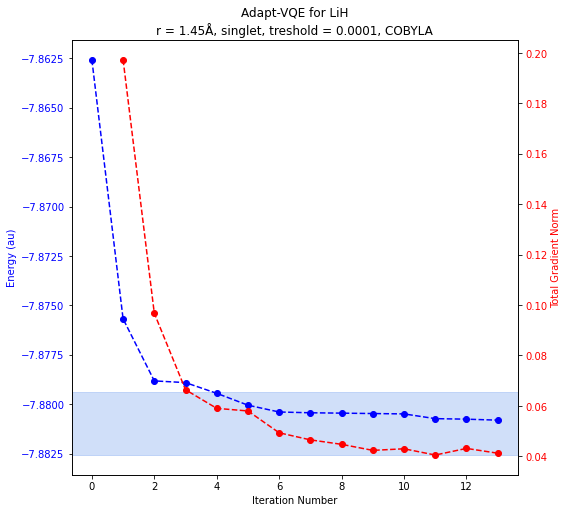

In [ ]:
# Typical energy graph, with or without gradient

data.plot()

### Comparing Runs

In [ ]:
data = removing
data2 = singlet

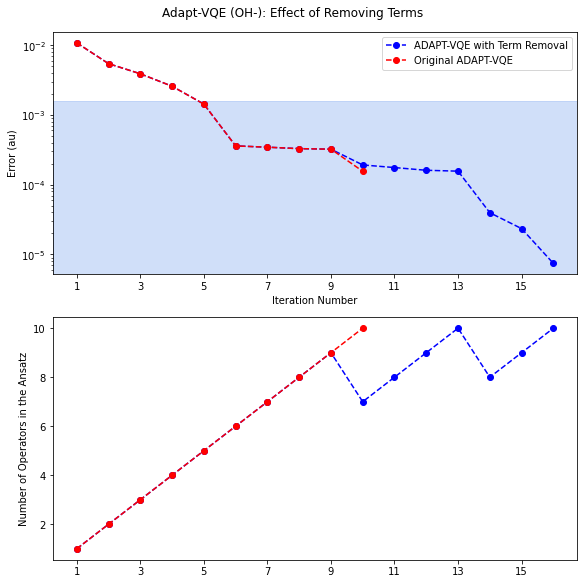

In [ ]:
# Comparing two runs.
# Error vs iteration number. Plotted below: number of operators in the ansatz.
# data -> removing
# data2 -> original 

energies = data.evolution["energies"]
energies2 = data2.evolution["energies"]

errors = list( map(lambda x: np.abs(molecule.fci_energy - x),energies) )
errors2 = list( map(lambda x: np.abs(molecule.fci_energy - x),energies2) )

# Maximum ansatz size to consider
max = 10

# Select the data from the original ADAPT-VQE. 
# Here position in list = number of operators in the ansatz - 1
errors2 = errors2[:max]

# Select the data from the term removing version.
# Here one must check the size of the ansatz because terms might've been 
#removed
last = len(errors)
for i in range(data.iterationCounter):
  if len(data.evolution["indices"][i]) > max:
    last = i
    break
    
errors = errors[:last]

fig, [ax1, ax2] = plt.subplots(2,figsize=[8,8],constrained_layout=True)

title = f"Adapt-VQE ({molecule.description}): Effect of Removing Terms"
plt.suptitle(title)

color1 = 'b'
ax1.plot(range(1,len(errors) + 1), 
         errors, 
         '--o',
         label = "ADAPT-VQE with Term Removal",
         color = color1)

ax1.plot(range(1,max + 1), 
         errors2, 
         '--o',
         label = "Original ADAPT-VQE",
         color = 'r')

# Shade area within chemical accuracy
exactEnergy = molecule.fci_energy
minAccuracy = 0
maxAccuracy = chemicalAccuracy
l = ax1.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

ax1.set_xlabel("Iteration Number")
ax1.set_ylabel("Error (au)")
ax1.set_yscale('log')

ax2.set_ylabel("Number of Operators in the Ansatz")

# Calculate ansatz size at the end of each iteration for the removing version
ansatzSize = [len(coefficients) for coefficients in data.evolution["coefficients"]]

ax2.plot(range(1,last + 1),
         ansatzSize[:last],
         '--o',
         color = 'b')

ax2.plot(range(1, max + 1),
         range(1, max + 1),
         '--o',
         color = 'r')


ax1.set_xticks(range(1,len(errors) + 1,2))
ax2.set_xticks(range(1,len(errors) + 1,2))

ax1.legend()

[]

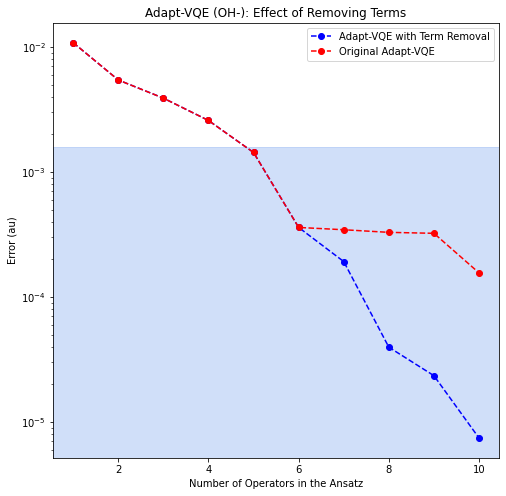

In [ ]:
# Comparing two runs.
# Error vs number of operators in the ansatz.
# MINIMUM number of operators. For the term removing version, the accuracy for 
#a certain ansatz size is the last (best) accuracy for that size. It doesn't 
#mean that a longer ansatz wasn't reached before.

# Choose maximum ansatz size to consider. Taken at the end of the iteration
#for the removing version
maxAnsatz = 10
energiesBySize = [0 for _ in range(maxAnsatz)]

# For the term removing version, select the best ansatz for a given number of 
#terms. This will be the last ansatz with that number of terms.
# The latest entries in the list aren't necessarily accurate, because the algorithm
#didn't have iterations enough to explore further. It's possible that if so,
#a better ansatz of that size would have been found.
for ansatzSize  in range(1,maxAnsatz + 1):
  for (i,energy) in enumerate(data.evolution["energies"]):
    if len(data.evolution["coefficients"][i]) <= ansatzSize:
      energiesBySize[ansatzSize-1] = energy

fig = plt.subplots(figsize=[8,8])
errors = list( map(lambda x: np.abs(molecule.fci_energy - x),energiesBySize) )[:maxAnsatz]
errors2 = list( map(lambda x: np.abs(molecule.fci_energy - x),energies2) )[:maxAnsatz]
plt.yscale('log')

plt.plot(range(1,len(errors)+1),
         errors,
         '--o',
         label = "Adapt-VQE with Term Removal",
         color = 'b')

plt.plot(range(1,len(errors2)+1),
         errors2,
         '--o',
         label = "Original Adapt-VQE",
         color = 'r')

plt.ylabel("Error (au)")
plt.xlabel("Number of Operators in the Ansatz")

plt.legend()
plt.title(f"Adapt-VQE ({molecule.description}): Effect of Removing Terms")

minAccuracy = 0
maxAccuracy = chemicalAccuracy
l = plt.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

plt.plot()

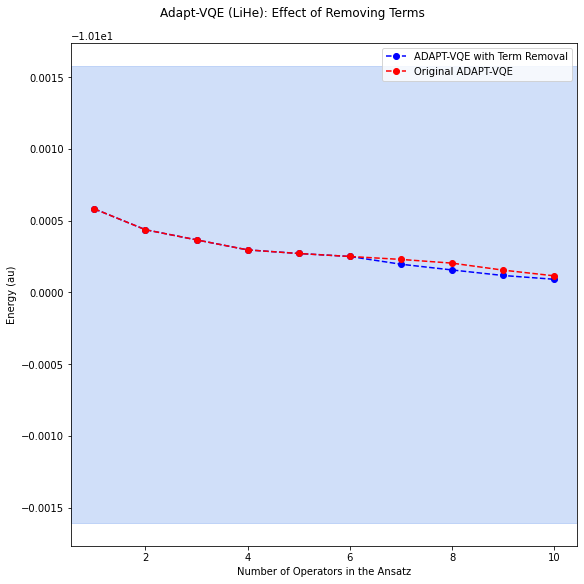

In [ ]:
# Comparing two runs
# Energy vs number of operators in the ansatz

fig, ax1 = plt.subplots(figsize=[8,8],constrained_layout=True)

title = f"Adapt-VQE ({molecule.description}): Effect of Removing Terms"
plt.suptitle(title)

color1 = 'b'
ax1.plot(range(1,maxAnsatz + 1), 
         energiesBySize[:maxAnsatz], 
         '--o',
         label = "ADAPT-VQE with Term Removal",
         color = color1)

#previous: green
ax1.plot(range(1,maxAnsatz + 1),
         energies2[:maxAnsatz], 
         '--o',
         label = "Original ADAPT-VQE",
         color = 'r')

# Shade area within chemical accuracy
exactEnergy = molecule.fci_energy
minAccuracy = exactEnergy - chemicalAccuracy
maxAccuracy = exactEnergy + chemicalAccuracy
l = ax1.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

ax1.set_xlabel("Number of Operators in the Ansatz")
ax1.set_ylabel("Energy (au)")

ax1.legend()

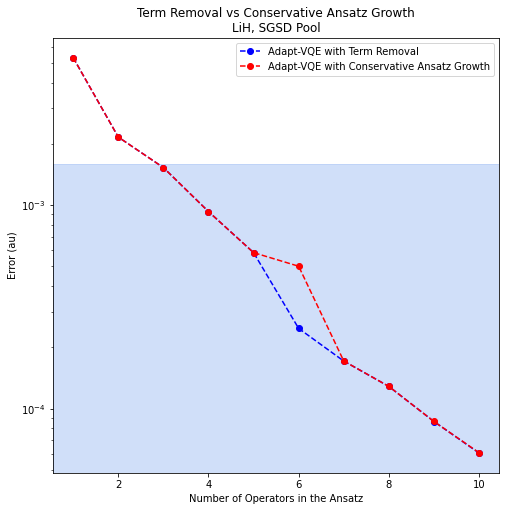

In [ ]:
# data -> removal
# data2 -Z conservative ansatz growth

molecule = liH
poolName = "SGSD Pool"

# Choose maximum ansatz size to consider. Taken at the end of the iteration
#for the removing version
maxAnsatz = 10
energiesBySize = [0 for _ in range(maxAnsatz)]

energies = data.evolution["energies"]
energies2 = data2.evolution["energies"]

# For the term removing version, select the best ansatz for a given number of 
#terms. This will be the last ansatz with that number of terms.
# The latest entries in the list aren't necessarily accurate, because the algorithm
#didn't have iterations enough to explore further. It's possible that if so,
#a better ansatz of that size would have been found.
for ansatzSize  in range(1,maxAnsatz + 1):
  for (i,energy) in enumerate(data.evolution["energies"]):
    if len(data.evolution["coefficients"][i]) <= ansatzSize:
      energiesBySize[ansatzSize-1] = energy

fig = plt.subplots(figsize=[8,8])
errors = list( map(lambda x: np.abs(molecule.fci_energy - x),energiesBySize) )[:maxAnsatz]
errors2 = list( map(lambda x: np.abs(molecule.fci_energy - x),energies2) )[:maxAnsatz]
plt.yscale('log')

plt.plot(range(1,len(errors)+1),
         errors,
         '--o',
         label = "Adapt-VQE with Term Removal",
         color = 'b')

plt.plot(range(1,len(errors2)+1),
         errors2,
         '--o',
         label = "Adapt-VQE with Conservative Ansatz Growth",
         color = 'r')

plt.ylabel("Error (au)")
plt.xlabel("Number of Operators in the Ansatz")

plt.legend()
plt.title("Term Removal vs Conservative Ansatz Growth\n"
          f"{molecule.description}, {poolName}")

minAccuracy = 0
maxAccuracy = chemicalAccuracy
l = plt.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

### Comparing Pools

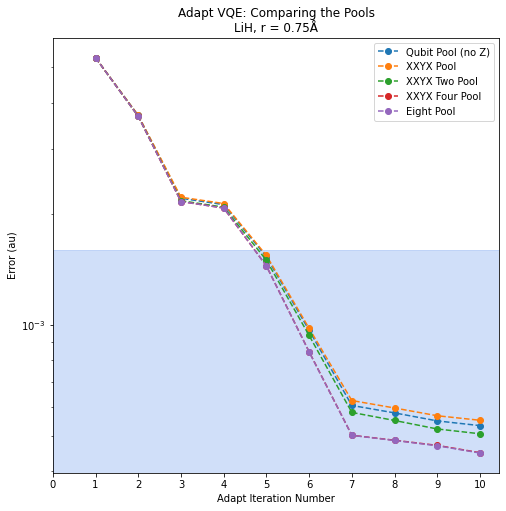

In [ ]:
fig = plt.subplots(figsize=[8,8])

title = "Adapt VQE: Comparing the Pools"
title += "\n{}, r = {}Å".format(molecule.description,
                              str(bondLength))

plt.title(title)

start = 0
stop = eight.iterationCounter

energies0 = [x-molecule.fci_energy for x in noZ.evolution["energies"]][start:stop]
#energies1 = [x-molecule.fci_energy for x in singlet.evolution["energies"]][start:stop]
#energies2 = [x-molecule.fci_energy for x in sc.evolution["energies"]][start:stop]
energies3 = [x-molecule.fci_energy for x in one.evolution["energies"]][start:stop]
energies4 = [x-molecule.fci_energy for x in two.evolution["energies"]][start:stop]
energies5 = [x-molecule.fci_energy for x in four.evolution["energies"]][start:stop]
energies6 = [x-molecule.fci_energy for x in eight.evolution["energies"]][start:stop]
#energies7 = [x-molecule.fci_energy for x in gsd.evolution["energies"]][start:stop]

plt.plot(range(start+1,stop+1),energies0, '--o',label = "Qubit Pool (no Z)")
#plt.plot(range(start+1,stop+1),energies1, '--o',label = "SGSD Pool")
#plt.plot(range(start+1,stop+1),energies2, '--o',label = "SC Pool")
plt.plot(range(start+1,stop+1),energies3, '--o',label = "XXYX Pool")
plt.plot(range(start+1,stop+1),energies4, '--o',label = "XXYX Two Pool")
plt.plot(range(start+1,stop+1),energies5, '--o',label = "XXYX Four Pool")
plt.plot(range(start+1,stop+1),energies6, '--o',label = "Eight Pool")
#plt.plot(range(start+1,stop+1),energies7, '--o',label = "GSD Pool")

plt.ylabel("Error (au)")
plt.xlabel("Adapt Iteration Number")
minAccuracy = 0
maxAccuracy = chemicalAccuracy
l = plt.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

plt.xticks(range(start,stop+1,int((stop-start)/10)))
plt.yscale('log')
plt.legend()

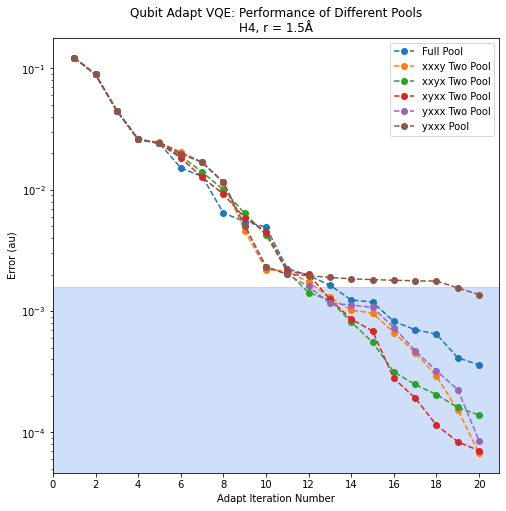

In [ ]:
fig = plt.subplots(figsize=[8,8])

title = "Qubit Adapt VQE: Performance of Different Pools"
title += "\n{}, r = {}Å".format(molecule.description,
                              str(bondLength))

plt.title(title)

start = 0
stop = 20

energies0 = [x-h4.fci_energy for x in qubit.evolution["energies"]][start:stop]
energies1 = [x-h4.fci_energy for x in xxxyTwo.evolution["energies"]][start:stop]
energies2 = [x-h4.fci_energy for x in xxyxTwo.evolution["energies"]][start:stop]
energies3 = [x-h4.fci_energy for x in xyxxTwo.evolution["energies"]][start:stop]
energies4 = [x-h4.fci_energy for x in yxxxTwo.evolution["energies"]][start:stop]
energies5 = [x-h4.fci_energy for x in yxxx.evolution["energies"]][start:stop]

plt.plot(range(start+1,stop+1),energies0, '--o',label = "Full Pool")
plt.plot(range(start+1,stop+1),energies1, '--o',label = "xxxy Two Pool")
plt.plot(range(start+1,stop+1),energies2, '--o',label = "xxyx Two Pool")
plt.plot(range(start+1,stop+1),energies3, '--o',label = "xyxx Two Pool")
plt.plot(range(start+1,stop+1),energies4, '--o',label = "yxxx Two Pool")
plt.plot(range(start+1,stop+1),energies5, '--o',label = "yxxx Pool")

plt.ylabel("Error (au)")
plt.xlabel("Adapt Iteration Number")
minAccuracy = 0
maxAccuracy = chemicalAccuracy
l = plt.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

plt.xticks(range(start,stop+1,int((stop-start)/10)))

plt.yscale('log')
plt.legend()

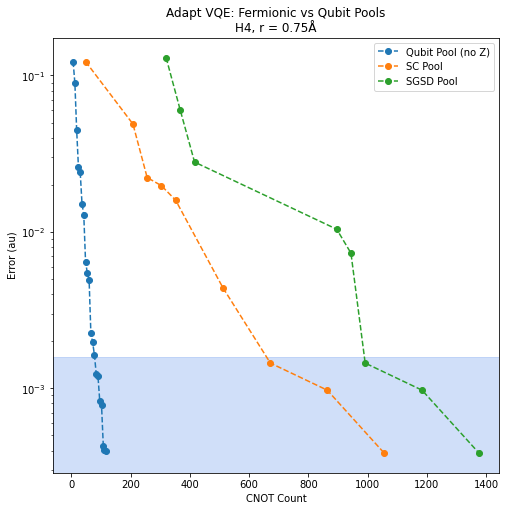

In [ ]:
# CNOT count on the x axis

qubitCNOTs = []
for indices in noZ.evolution["indices"]:
  ansatz = [noZQubitPool[i] for i in indices]
  cnots = countCNOTs(ansatz)
  qubitCNOTs.append(cnots)

sgsdCNOTs = []
for indices in sgsd.evolution["indices"]:
  ansatz = [singlet_gsd[i] for i in indices]
  cnots = countCNOTs(ansatz)
  sgsdCNOTs.append(cnots)

scCNOTs = []
for indices in sc.evolution["indices"]:
  ansatz = [spin_complement_gsd[i] for i in indices]
  cnots = countCNOTs(ansatz)
  scCNOTs.append(cnots)

fig = plt.subplots(figsize=[8,8])

title = "Adapt VQE: Fermionic vs Qubit Pools"
title += "\n{}, r = {}Å".format(molecule.description,
                              str(bondLength))

plt.title(title)

start = 0
stop = 20

energies0 = [x-h4.fci_energy for x in noZ.evolution["energies"]][start:stop]
energies1 = [x-h4.fci_energy for x in sc.evolution["energies"]][start:stop]
energies2 = [x-h4.fci_energy for x in sgsd.evolution["energies"]][start:stop]

maxAccuracy = energies0[-1]

for (i,accuracy) in enumerate(energies1):
  if accuracy < maxAccuracy:
    break
scLast = i + 1

for (i,accuracy) in enumerate(energies2):
  if accuracy < maxAccuracy:
    break
sgsdLast = i + 1

plt.plot(qubitCNOTs,energies0, '--o',label = "Qubit Pool (no Z)")
plt.plot(scCNOTs[:scLast],energies1[:scLast], '--o',label = "SC Pool")
plt.plot(sgsdCNOTs[:sgsdLast],energies2[:sgsdLast], '--o',label = "SGSD Pool")

plt.ylabel("Error (au)")
plt.xlabel("CNOT Count")
minAccuracy = 0
maxAccuracy = chemicalAccuracy
l = plt.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

plt.yscale('log')
plt.legend()

In [ ]:
# CNOT count on the x axis
eight=data
qubitCNOTs = []
for indices in noZ.evolution["indices"]:
  ansatz = [noZQubitPool[i] for i in indices]
  cnots = countCNOTs(ansatz)
  qubitCNOTs.append(cnots)

eightCNOTs = []
for indices in eight.evolution["indices"]:
  ansatz = [eightPool[i] for i in indices]
  cnots = countCNOTs(ansatz)
  cnots = countEightPoolCNOTs(ansatz)
  eightCNOTs.append(cnots)

fig = plt.subplots(figsize=[8,8])

title = "Adapt VQE: Qubit vs Eight Pool"
title += "\n{}, r = {}Å".format(molecule.description,
                              str(bondLength))

plt.title(title)

start = 0
stop = 20

energies0 = [x-h4.fci_energy for x in noZ.evolution["energies"]][start:stop]
energies1 = [x-h4.fci_energy for x in eight.evolution["energies"]][start:stop]

'''
plt.plot(range(start+1,stop+1),energies0, '--o',label = "Qubit Pool (no Z)")
plt.plot(range(start+1,stop+1),energies1, '--o',label = "Eight Pool")
'''
maxAccuracy = energies0[stop-1]

for (i,accuracy) in enumerate(energies1):
  if accuracy < maxAccuracy:
    break
eightLast = eight.iterationCounter#i + 1
print(eightLast)

plt.plot(qubitCNOTs[start:stop],energies0[start:stop], '--o',label = "Qubit Pool (no Z)")
plt.plot(eightCNOTs[:eightLast],energies1[:eightLast], '--o',label = "Eight Pool")

plt.ylabel("Error (au)")
plt.xlabel("Adapt-VQE Iteration")
#plt.xlabel("CNOT Count")
minAccuracy = 0
maxAccuracy = chemicalAccuracy
l = plt.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

#plt.xticks(range(start,stop+1,int((stop-start)/10)))

plt.yscale('log')
plt.legend()

### Evolution of Selected Gradient and Energy Change

Text(0, 0.5, 'Selected Gradient Norm')

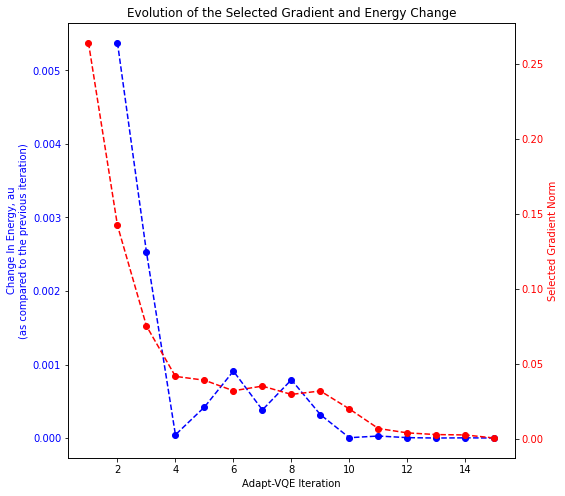

In [ ]:
# *Change* in energy/gradient here.
# Important: the gradient norm is calculated in the beginning
#of each iteration. So the change induced by a given iteration
#is felt in the gradient norm of the following one. To compare,
#it's best to plot the gradient change as induced by the iteration
#(i.e., iteration i <-> gradient change produced by iteration i
# = initial gradient in iteration i+1 - initial gradient in 
#iteration i)

energies = data.evolution["energies"]
gradients = data.evolution["totalNorm"]
selectedGradient = data.evolution["selectedGradient"]

length = len(energies)
energyChange = [np.abs(current - previous) for (current,previous) in 
          zip(energies[1:length],energies[:length-1])]

gradientChange = [np.abs(current - previous) for (current,previous) in 
          zip(gradients[1:length],gradients[:length-1])]

fig, ax1 = plt.subplots(figsize=[8,8])

color1 = 'b'
ax1.plot(range(2,length+1), energyChange, '--o', color = color1)

#plt.plot(range(2,length+1),energyChange,label = "Energy")
#plt.plot(range(2,length+1),gradientChange)
#plt.legend()
ax1.set_title("Evolution of the Selected Gradient and Energy Change")
ax1.set_xlabel("Adapt-VQE Iteration")
ax1.tick_params(axis='y', labelcolor = color1)
ax1.set_ylabel("Change In Energy, au\n"
                "(as compared to the previous iteration)", 
               color = color1)

color2 = 'r'
ax2 = ax1.twinx()
ax2.plot(range(1,length+1), selectedGradient, '--o', color = color2)
ax2.tick_params(axis='y', labelcolor = color2)
ax2.set_ylabel("Selected Gradient Norm",
               color = color2)

### Evolution of the Coefficients

In [ ]:
# Evolution of the optimized coefficients

data = myAdapt.data

# Absolute values vs % change 
change = False

# If change == True: choose if reference is fixed (at 0). If not, the change 
#from the previous reference will be considered
fixedReference = False

iterationLabels = [iterationLabel
                   for iterationLabel in range(1,data.iterationCounter+1)]

coefEvolutions = {}
for operator in range(data.iterationCounter):
  coefEvolutions[operator] = []

for iteration in range(data.iterationCounter):
  iterationCoefficients = data.evolution["coefficients"][iteration]

  for operator in range(iteration+1):
    iterationCoefficient = iterationCoefficients[operator]
    coefEvolutions[operator].append(iterationCoefficient)

plt.figure(figsize=[8,8])

#for operator in [2]:
for operator in range(myAdapt.data.iterationCounter):

  if change:
    opCoefs = coefEvolutions[operator]

    if fixedReference:
      initialCoef = opCoefs[0]
      percentages = (opCoefs-initialCoef)/initialCoef * 100

      plt.plot(iterationLabels[operator:],
               percentages,
              '--o',
               label = operator)
      
      plt.ylabel("Percentual Change of the Coefficient Value\n"
                  "(as compared to the first iteration)")

    else:
      length = len(opCoefs)
      change = [np.abs(current - previous) for (current,previous) in 
                zip(opCoefs[1:length],opCoefs[:length-1])]

      plt.plot(iterationLabels[operator+1:],
               change,
               '--o',
               label = operator)
      
      plt.ylabel("Absolute Percentual Change of the Coefficient Value\n"
                  "(as compared to the previous iteration)")
  
  else:
    plt.plot(iterationLabels[operator:],
             coefEvolutions[operator],
             '--o',
             label = operator)
    plt.ylabel("Coefficient Value")


plt.title("Evolution of the Optimized Coefficients")
plt.xlabel("Adapt Iteration Number")
plt.legend()
plt.plot()

### Effect of Removing the Z Strings

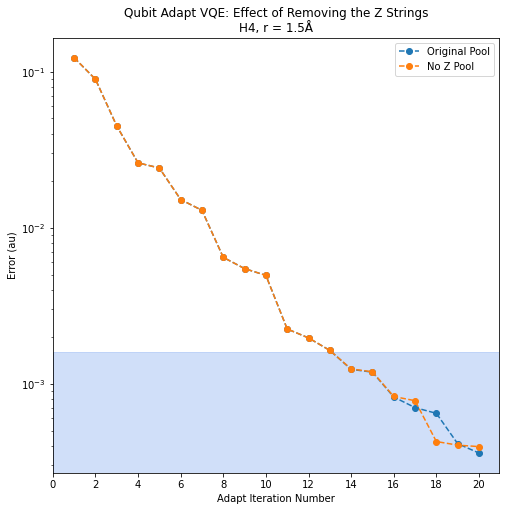

In [ ]:
# Plotting the effect of removing the anticommutation string from the operators

fig = plt.subplots(figsize=[8,8])

title = "Qubit Adapt VQE: Effect of Removing the Z Strings"
title += "\n{}, r = {}Å".format(molecule.description,
                              str(bondLength))

plt.title(title)

start = 0
stop = 20

energies0 = [x-h4.fci_energy for x in qubit.evolution["energies"]][start:stop]
energies1 = [x-h4.fci_energy for x in noZ.evolution["energies"]][start:stop]

plt.plot(range(start+1,stop+1),energies0, '--o',label = "Original Pool")
plt.plot(range(start+1,stop+1),energies1, '--o',label = "No Z Pool")

plt.ylabel("Error (au)")
plt.xlabel("Adapt Iteration Number")
minAccuracy = 0
maxAccuracy = chemicalAccuracy
l = plt.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

plt.xticks(range(start,stop+1,int((stop-start)/10)))

plt.yscale('log')
plt.legend()

### Evolution of the Slater Determinants in the State

In [ ]:
myData = data
poolName = "XXYX Four"
poolName = "Eight"

In [ ]:
badCounts, badProb = evaluateAdaptSDs(myData,
                                         sparseReferenceState,
                                         myData.sparsePool)

correctSDList, badSpinList, badNumberList = badCounts

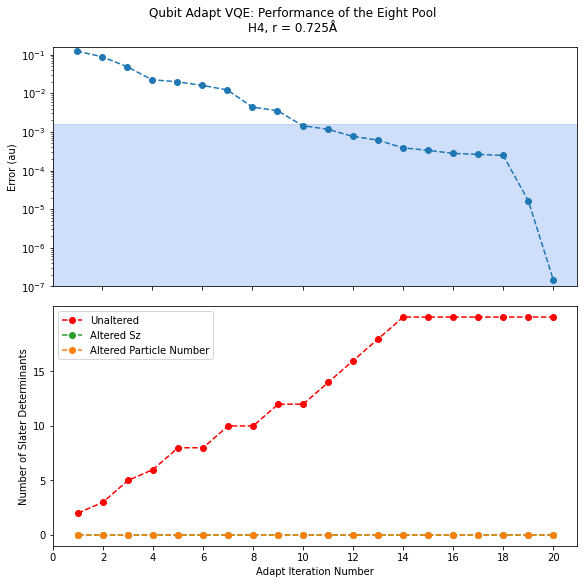

In [ ]:
# Plot evolution of the energy and gradient along the optimization, 
#along with the number of fully correct Slater determinants in the superposition,
#and the number of determinants with wrong Sz / particle number.

fig, axs = plt.subplots(2,figsize=[8,8],constrained_layout=True,sharex=True)

title = "Qubit Adapt VQE: Performance of the {} Pool".format(poolName)
title += "\n{}, r = {}Å".format(molecule.description,
                              str(bondLength))

plt.suptitle(title)

start = 0
stop = 20

energies2 = [x-h4.fci_energy for x in myData.evolution["energies"]][start:stop]

axs[0].plot(range(start+1,stop+1),energies2, '--o')

axs[0].set_ylabel("Error (au)")
axs[0].set_yscale('log')
axs[0].set_ylim([10**-7,10**(-0.8)])

minAccuracy = 0
maxAccuracy = chemicalAccuracy
l = axs[0].axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

axs[1].plot(range(start+1,stop+1),
         correctSDList[start:stop], 
         '--o',
         label = "Unaltered", color = 'r')

axs[1].plot(range(start+1,stop+1),
         badSpinList[start:stop], 
         '--o',
         label = "Altered Sz", 
         color = 'tab:green')

axs[1].plot(range(start+1,stop+1),
         badNumberList[start:stop], 
         '--o',
         label = "Altered Particle Number", 
         color = 'tab:orange')

axs[1].set_ylabel("Number of Slater Determinants")

axs[1].set_yticks(range(0,correctSDList[-1],5))

plt.xticks(range(start,stop+1,int((stop-start)/10)))
axs[1].set_xlabel("Adapt Iteration Number")

plt.legend()

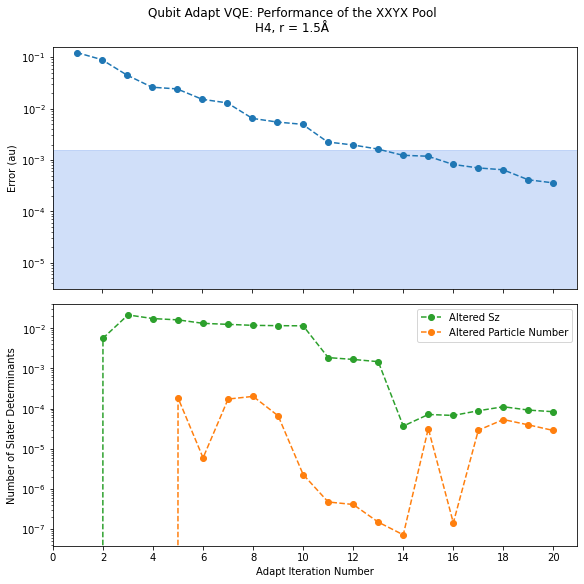

In [ ]:
# Plot evolution of the energy and gradient along the optimization, 
#along with the number of fully correct Slater determinants in the superposition,
#and the number of determinants with wrong Sz / particle number.

fig, axs = plt.subplots(2,figsize=[8,8],constrained_layout=True,sharex=True)

title = "Qubit Adapt VQE: Performance of the {} Pool".format(poolName)
title += "\n{}, r = {}Å".format(molecule.description,
                              str(bondLength))

plt.suptitle(title)

start = 0
stop = 20

energies2 = [x-h4.fci_energy for x in myData.evolution["energies"]][start:stop]

axs[0].plot(range(start+1,stop+1),energies2, '--o')

axs[0].set_ylabel("Error (au)")
axs[0].set_yscale('log')
axs[0].set_ylim([10**-5.5,10**(-0.8)])

minAccuracy = 0
maxAccuracy = chemicalAccuracy
l = axs[0].axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')
'''
axs[1].plot(range(start+1,stop+1),
         correctProbList[start:stop], 
         '--o',
         label = "Unaltered", color = 'r')
'''
axs[1].plot(range(start+1,stop+1),
         badSpinProbList[start:stop], 
         '--o',
         label = "Altered Sz", 
         color = 'tab:green')

axs[1].plot(range(start+1,stop+1),
         badNumberProbList[start:stop], 
         '--o',
         label = "Altered Particle Number", 
         color = 'tab:orange')

axs[1].set_ylabel("Number of Slater Determinants")

#axs[1].set_yticks(range(0,correctSDList[-1],5))
axs[1].set_yscale('log')
plt.xticks(range(start,stop+1,int((stop-start)/10)))
axs[1].set_xlabel("Adapt Iteration Number")

plt.legend()

[]

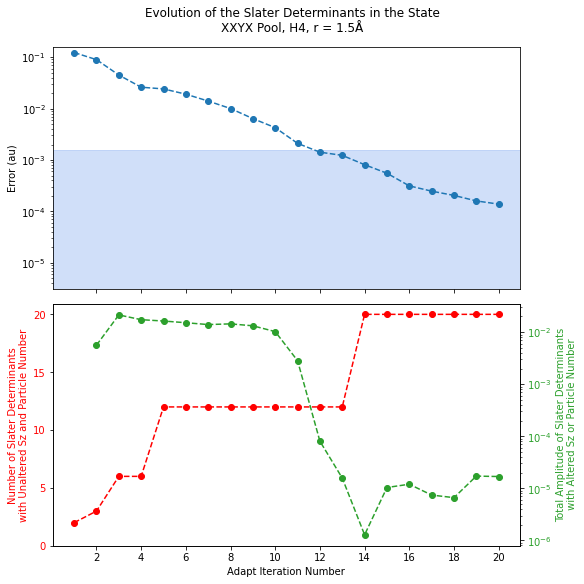

In [ ]:
# Plot evolution of the energy and gradient along the optimization, 
#along with the number of fully correct Slater determinants in the superposition,
#and the number of determinants with wrong Sz / particle number.

fig, axs = plt.subplots(2,figsize=[8,8],constrained_layout=True,sharex=True)

title = "Evolution of the Slater Determinants in the State\n"
title += "{} Pool, {}, r = {}Å".format(poolName,
                                  molecule.description,
                                  str(bondLength))

plt.suptitle(title)

start = 0
stop = 20

energies2 = [x-h4.fci_energy for x in myData.evolution["energies"]][start:stop]

axs[0].plot(range(start+1,stop+1),energies2, '--o')

axs[0].set_ylabel("Error (au)")
axs[0].set_yscale('log')
axs[0].set_ylim([10**-5.5,10**(-0.8)])

minAccuracy = 0
maxAccuracy = chemicalAccuracy
l = axs[0].axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

color1 = 'r'
axs[1].plot(range(start+1,stop+1),
         correctSDList[start:stop], 
         '--o',
         label = "Unaltered", color = color1)
axs[1].tick_params(axis='y', labelcolor = color1)

axs[1].set_ylabel("Number of Slater Determinants\n" 
                  "with Unaltered Sz and Particle Number", 
                  color = color1)
axs[1].set_xlabel("Adapt Iteration Number")
axs[1].set_yticks(range(0,correctSDList[-1]+1,5))

axs2 = axs[1].twinx()

color2 = 'tab:green'
axs2.plot(range(start+1,stop+1),
         badProb[start:stop], 
         '--o',
         color = color2)
axs2.set_ylabel("Total Amplitude of Slater Determinants"
                "\n with Altered Sz or Particle Number",
                color = color2)
axs2.tick_params(axis='y', labelcolor = color2)
#axs[1].set_yticks(range(10*(-5),10*(-1),5))

axs2.set_yscale('log', nonposy = 'mask')

plt.xticks(range(start,stop+1,int((stop-start)/10)))

plt.plot()

In [ ]:
badCounts1, badProb1 = evaluateAdaptSDs(xxyx,
                                        sparseReferenceState,
                                        xxyx.sparsePool)
badCounts2, badProb2 = evaluateAdaptSDs(xxyxTwo,
                                        sparseReferenceState,
                                        xxyxTwo.sparsePool)
badCounts3, badProb3 = evaluateAdaptSDs(qubit,
                                        sparseReferenceState,
                                        qubit.sparsePool)
badCounts4, badProb4 = evaluateAdaptSDs(noZ,
                                        sparseReferenceState,
                                        noZ.sparsePool)

correctSDList1, badSpinList1, badNumberList1 = badCounts1
correctSDList2, badSpinList2, badNumberList2 = badCounts2
correctSDList3, badSpinList3, badNumberList3 = badCounts3
correctSDList4, badSpinList4, badNumberList4 = badCounts4

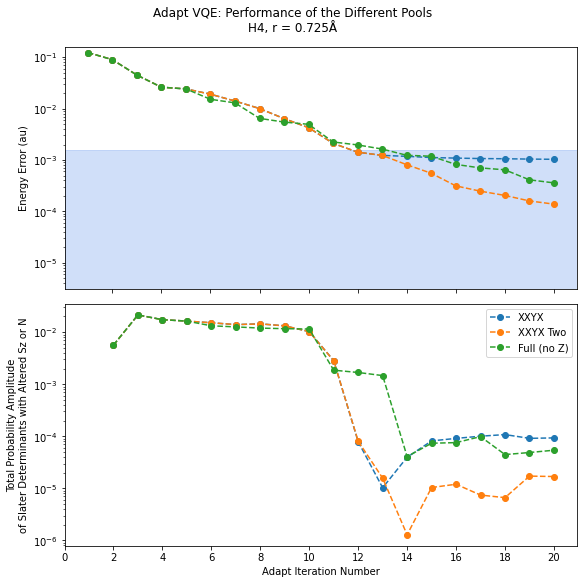

In [ ]:
# Plot evolution of the energy along the optimization, 
#along with the total probability amplitude of states with altered Sz or N

fig, axs = plt.subplots(2,figsize=[8,8],constrained_layout=True,sharex=True)

title = "Adapt VQE: Performance of the Different Pools"
title += "\n{}, r = {}Å".format(molecule.description,
                              str(bondLength))

plt.suptitle(title)

start = 0
stop = 20

energies1 = [x-h4.fci_energy for x in xxyx.evolution["energies"]][start:stop]
energies2 = [x-h4.fci_energy for x in xxyxTwo.evolution["energies"]][start:stop]
energies3 = [x-h4.fci_energy for x in qubit.evolution["energies"]][start:stop]

axs[0].plot(range(start+1,stop+1),energies1, '--o')
axs[0].plot(range(start+1,stop+1),energies2, '--o')
axs[0].plot(range(start+1,stop+1),energies3, '--o')

axs[0].set_ylabel("Energy Error (au)")
axs[0].set_yscale('log')
axs[0].set_ylim([10**-5.5,10**(-0.8)])

minAccuracy = 0
maxAccuracy = chemicalAccuracy
l = axs[0].axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

axs[1].plot(range(start+1,stop+1),
         badProb1[start:stop], 
         '--o',
         label = "XXYX")
axs[1].plot(range(start+1,stop+1),
         badProb2[start:stop], 
         '--o',
         label = "XXYX Two")
axs[1].plot(range(start+1,stop+1),
         badProb4[start:stop], 
         '--o',
         label = "Full (no Z)")

axs[1].set_ylabel("Total Probability Amplitude\n"
                  "of Slater Determinants with Altered Sz or N")

axs[1].set_yticks(range(10*(-5),10*(-1),5))
axs[1].set_yscale('log',nonposy='mask')
plt.xticks(range(start,stop+1,int((stop-start)/10)))
axs[1].set_xlabel("Adapt Iteration Number")

plt.legend()